## Description of Notebook

The notebook is used to test ML approach on the VDF statistical momenta, anisotropies, and particle fraction numbers

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

## Test 1. Preparation of the data set for regression.

The regression will be considered with respect to the anisotropy change rate. Various scalings for the anisotropy will be considered to predict the regression rates, depending on how the rate space is structured. Our task is to 'flatten' a bit the near-zero distribution corresponding to the small growing rates, yet important to predict.

First, let us load the anisotropy change rates and investigate how they are structured. Given that some He anisotropies are zeros, we can (only for the purpose of having non-zero entries) make them equal to proton anisotropies.

In [11]:
rates_an = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_an_re_all.npy')

In [12]:
for i in range (0, rates_an.shape[0], 1):
    if (rates_an[i,1] == 0): rates_an[i,1] = rates_an[i,0]

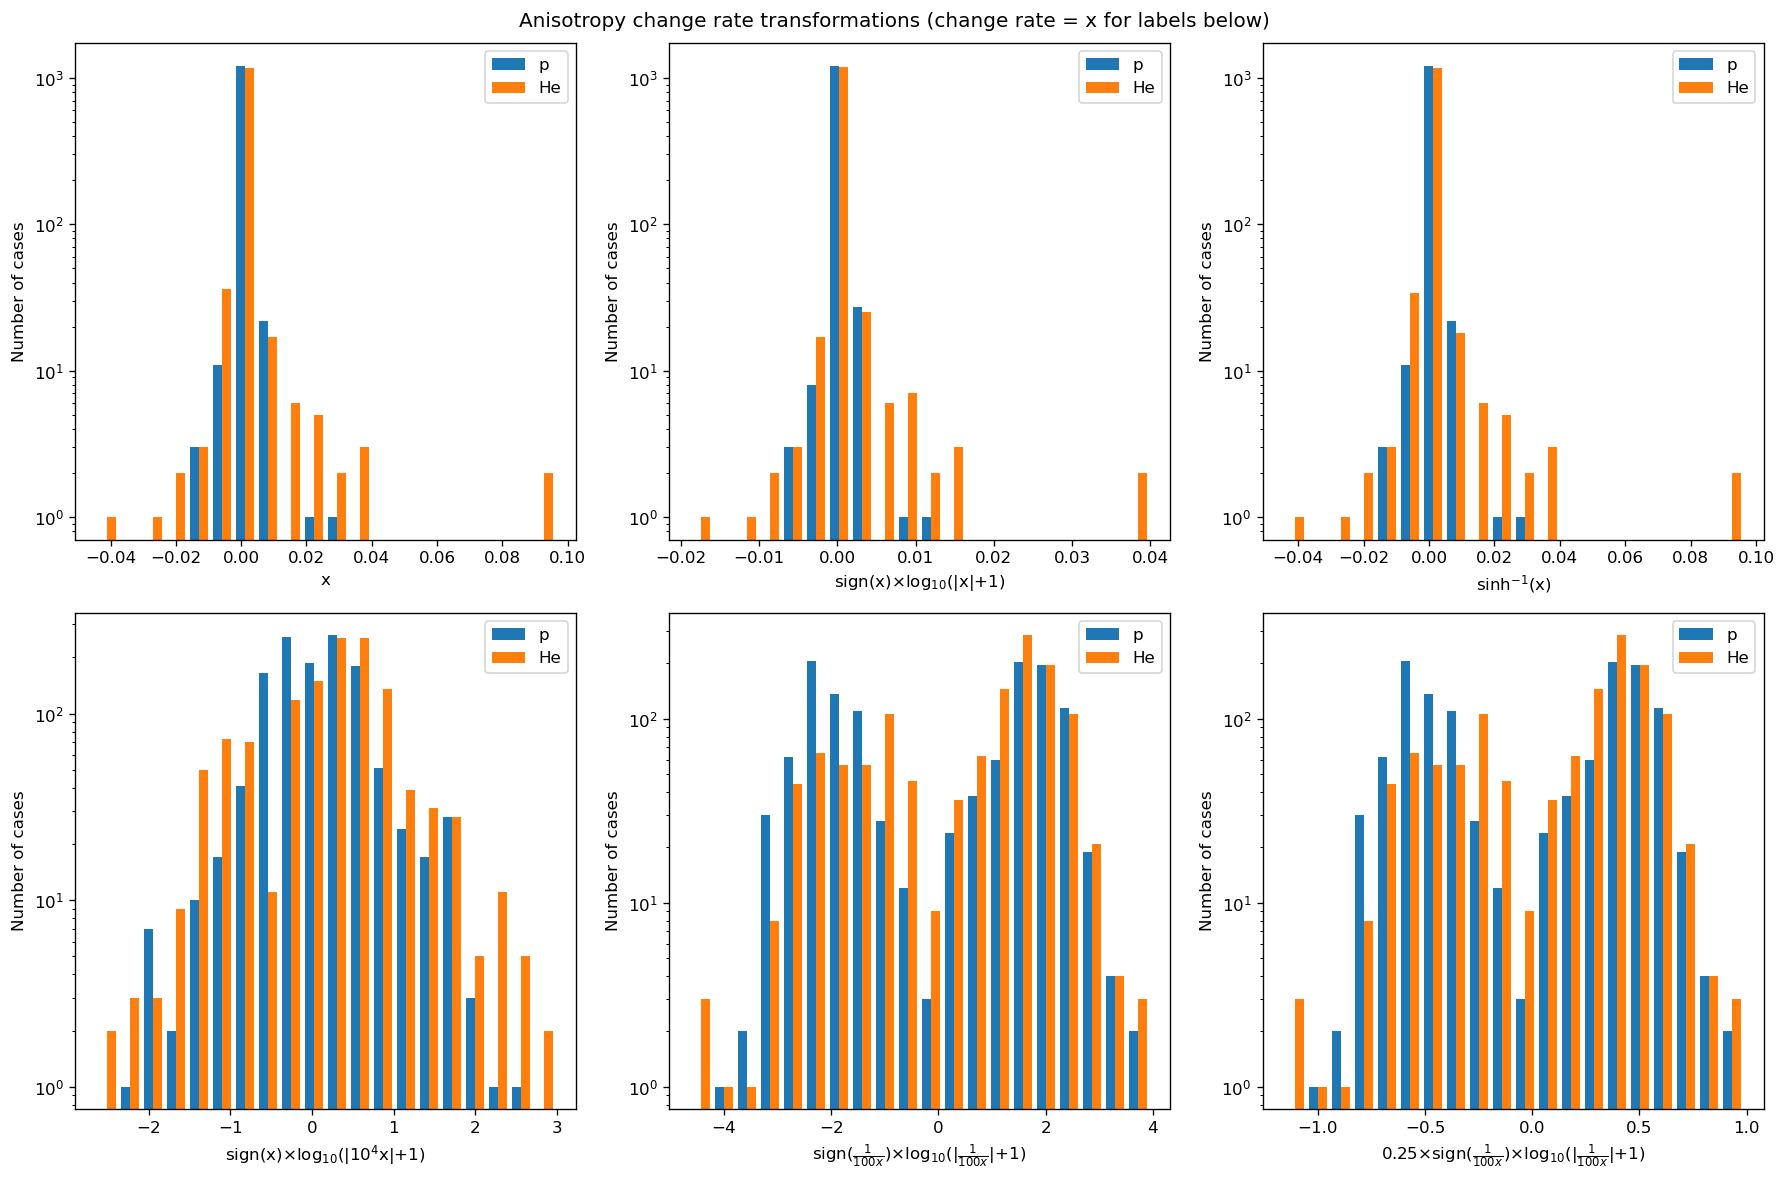

In [13]:
im, ax = plt.subplots(2, 3, figsize = (15, 10), dpi=120)

plt.suptitle('Anisotropy change rate transformations (change rate = x for labels below)')

ax[0,0].hist(rates_an,bins=20,label=['p','He'])
ax[0,0].set(xlabel='x', ylabel='Number of cases', yscale='log')
ax[0,0].legend()

ax[0,1].hist(np.sign(rates_an) * np.log10(np.abs(rates_an) + 1.0), bins=20,label=['p','He'])
ax[0,1].set(xlabel=r'sign(x)$\times$log$_{10}$(|x|+1)', ylabel='Number of cases', yscale='log')
ax[0,1].legend()

ax[0,2].hist(np.arcsinh(rates_an), bins=20,label=['p','He'])
ax[0,2].set(xlabel=r'sinh$^{-1}$(x)', ylabel='Number of cases', yscale='log')
ax[0,2].legend()

ax[1,0].hist(np.sign(1.0e4*rates_an) * np.log10(np.abs(1.0e4*rates_an) + 1.0),bins=20,label=['p','He'])
ax[1,0].set(xlabel=r'sign(x)$\times$log$_{10}$(|10$^4$x|+1)', ylabel='Number of cases', yscale='log')
ax[1,0].legend()

ax[1,1].hist(np.sign(0.01/rates_an) * np.log10(np.abs(0.01/rates_an) + 1.0),bins=20,label=['p','He'])
ax[1,1].set(xlabel=r'sign($\frac{1}{100x}$)$\times$log$_{10}$(|$\frac{1}{100x}$|+1)', ylabel='Number of cases', yscale='log')
ax[1,1].legend()

ax[1,2].hist(0.25*np.sign(0.01/rates_an) * np.log10(np.abs(0.01/rates_an) + 1.0),bins=20,label=['p','He'])
ax[1,2].set(xlabel=r'0.25$\times$sign($\frac{1}{100x}$)$\times$log$_{10}$(|$\frac{1}{100x}$|+1)', ylabel='Number of cases', yscale='log')
ax[1,2].legend()

plt.tight_layout()
plt.show()

Defining the forward and inverse transformations

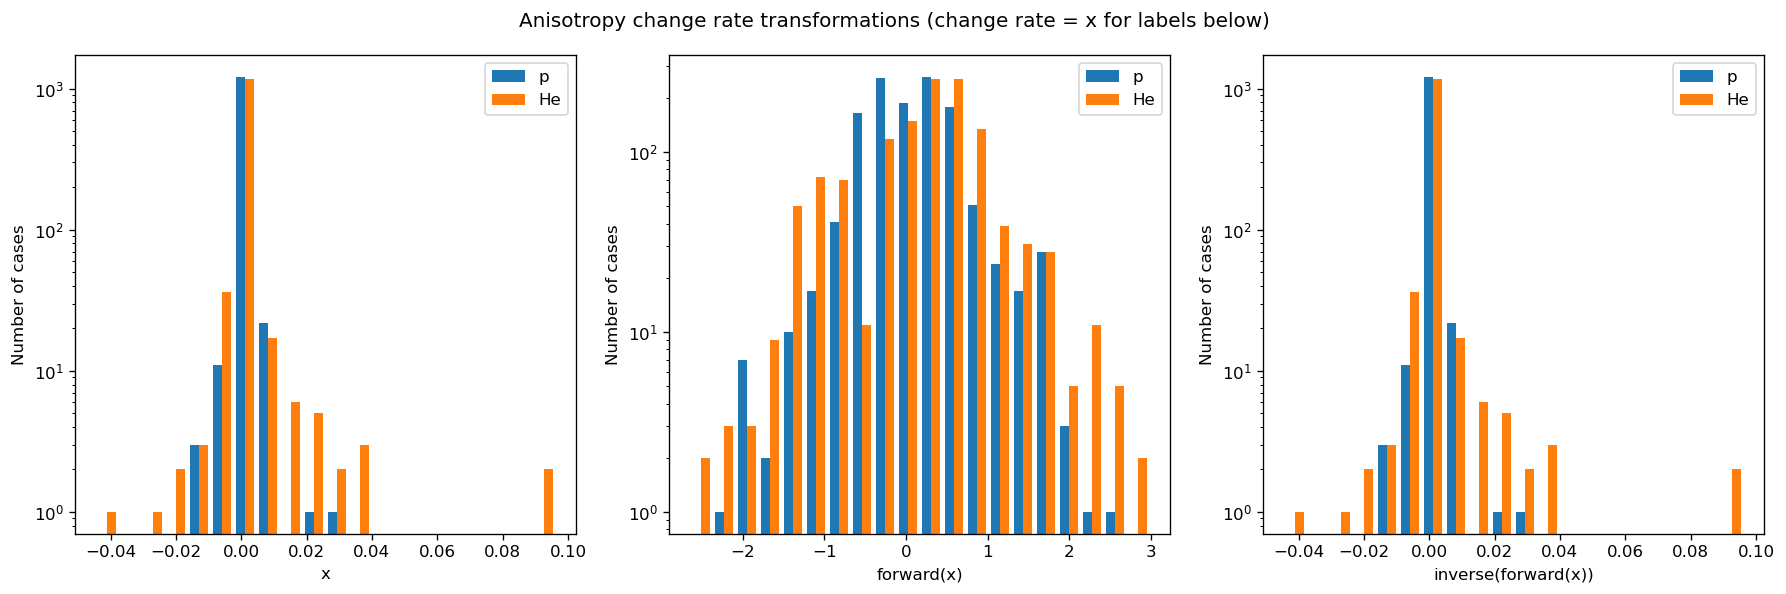

In [14]:
def transform_forward(x):
    return np.sign(x) * np.log10(np.abs(x*1.0e4) + 1.0)

def transform_inverse(x):
    return np.sign(x) * 1.0e-4 * (np.power(10.0,np.abs(x)) - 1.0)

im, ax = plt.subplots(1, 3, figsize = (15, 5), dpi=120)

plt.suptitle('Anisotropy change rate transformations (change rate = x for labels below)')

ax[0].hist(rates_an,bins=20,label=['p','He'])
ax[0].set(xlabel='x', ylabel='Number of cases', yscale='log')
ax[0].legend()

ax[1].hist(transform_forward(rates_an),bins=20,label=['p','He'])
ax[1].set(xlabel='forward(x)', ylabel='Number of cases', yscale='log')
ax[1].legend()

ax[2].hist(transform_inverse(transform_forward(rates_an)),bins=20,label=['p','He'])
ax[2].set(xlabel='inverse(forward(x))', ylabel='Number of cases', yscale='log')
ax[2].legend()

plt.tight_layout()
plt.show()

Loading the data set and normalizing the features

In [15]:
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.featurevector_allmoments_all.npy')
times_allmoments = np.load('./mldata_vdfmoments/allsimulations.timep_array_all.npy')

scaler = StandardScaler()
scaler.fit(featurevector_allmoments)
featurevector_allmoments = scaler.transform(featurevector_allmoments)

rates_an = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_an_re_all.npy')
for i in range (0, rates_an.shape[0], 1):
    if (rates_an[i,1] == 0): rates_an[i,1] = rates_an[i,0]
rates_an = transform_forward(rates_an)

In [16]:
data_split = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)

In [ ]:
def output_msescores(f_test, f_predicted):
    MSE_p = np.sqrt(np.mean(np.power(f_test[:,0] - f_predicted[:,0],2.0)))
    MSE_he = np.sqrt(np.mean(np.power(f_test[:,1] - f_predicted[:,1],2.0)))
    return MSE_p, MSE_he

# requires the transformation function to be defined, see below
def output_msescores_inverse(f_test, f_predicted):
    MSE_p = np.sqrt(np.mean(np.power(transform_inverse(f_test[:,0]) - transform_inverse(f_predicted[:,0]),2.0)))
    MSE_he = np.sqrt(np.mean(np.power(transform_inverse(f_test[:,1]) - transform_inverse(f_predicted[:,1]),2.0)))
    return MSE_p, MSE_he

Next, we introduce the grid search for the regression procedure. Everything is pretty much the same as for the classifier but with the regressor functions operating instead.

### Case 1. kNN regressor.

In [90]:
# parameter grid
param_grid = {'estimator__n_neighbors': [2, 5, 10, 25], \
              'estimator__p': [1, 2]}

# regressor and gridsearch
regressor = MultiOutputRegressor(KNeighborsRegressor())

grid_search = GridSearchCV(regressor, param_grid, cv=data_split, verbose=2)
grid_search.fit(featurevector_allmoments, rates_an)
print("Best parameters found: ", grid_search.best_params_)
best_params = grid_search.best_params_
base_regressor_params = {k.split('__')[1]: v for k, v in best_params.items()}

# fitting 10 times and accumulating the scores for the best model
pred_p = np.zeros([10], dtype=float)
pred_he = np.zeros([10], dtype=float)
pred_p_inv = np.zeros([10], dtype=float)
pred_he_inv = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(rates_an)):
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = rates_an[train_index], rates_an[test_index]
    regressor = MultiOutputRegressor(KNeighborsRegressor(**base_regressor_params))
    regressor.fit(X_train, f_train)
    f_predicted = regressor.predict(X_test)
    pred_p[i], pred_he[i] = output_msescores(f_test, f_predicted)
    pred_p_inv[i], pred_he_inv[i] = output_msescores_inverse(f_test, f_predicted)
    
print("MSE(p) = " + str(np.mean(pred_p)) + "+/-" + str(np.std(pred_p)))
print("MSE(He) = " + str(np.mean(pred_he)) + "+/-" + str(np.std(pred_he)))

print("MSE(p) = " + str(np.mean(pred_p_inv)) + "+/-" + str(np.std(pred_p_inv)))
print("MSE(He) = " + str(np.mean(pred_he_inv)) + "+/-" + str(np.std(pred_he_inv)))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] END ...........estimator__n_neighbors=2, estimator__p=1; total time=   0.0s
[CV] END ...........estimator__n_neighbors=2, estimator__p=1; total time=   0.0s
[CV] END ...........estimator__n_neighbors=2, estimator__p=1; total time=   0.0s
[CV] END ...........estimator__n_neighbors=2, estimator__p=1; total time=   0.0s
[CV] END ...........estimator__n_neighbors=2, estimator__p=1; total time=   0.0s
[CV] END ...........estimator__n_neighbors=2, estimator__p=1; total time=   0.0s
[CV] END ...........estimator__n_neighbors=2, estimator__p=1; total time=   0.0s
[CV] END ...........estimator__n_neighbors=2, estimator__p=1; total time=   0.0s
[CV] END ...........estimator__n_neighbors=2, estimator__p=1; total time=   0.0s
[CV] END ...........estimator__n_neighbors=2, estimator__p=1; total time=   0.0s
[CV] END ...........estimator__n_neighbors=2, estimator__p=2; total time=   0.0s
[CV] END ...........estimator__n_neighbors=2, es

### Case 2. Support vector regressor with RBF kernel

In [91]:
# parameter grid
param_grid = {'estimator__kernel': ['rbf'], \
              'estimator__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0], \
              'estimator__gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 'scale']}

# regressor and gridsearch
regressor = MultiOutputRegressor(SVR())

grid_search = GridSearchCV(regressor, param_grid, cv=data_split, verbose=2)
grid_search.fit(featurevector_allmoments, rates_an)
print("Best parameters found: ", grid_search.best_params_)
best_params = grid_search.best_params_
base_regressor_params = {k.split('__')[1]: v for k, v in best_params.items()}

# fitting 10 times and accumulating the scores for the best model
pred_p = np.zeros([10], dtype=float)
pred_he = np.zeros([10], dtype=float)
pred_p_inv = np.zeros([10], dtype=float)
pred_he_inv = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(rates_an)):
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = rates_an[train_index], rates_an[test_index]
    regressor = MultiOutputRegressor(SVR(**base_regressor_params))
    regressor.fit(X_train, f_train)
    f_predicted = regressor.predict(X_test)
    pred_p[i], pred_he[i] = output_msescores(f_test, f_predicted)
    pred_p_inv[i], pred_he_inv[i] = output_msescores_inverse(f_test, f_predicted)
    
print("MSE(p) = " + str(np.mean(pred_p)) + "+/-" + str(np.std(pred_p)))
print("MSE(He) = " + str(np.mean(pred_he)) + "+/-" + str(np.std(pred_he)))

print("MSE(p) = " + str(np.mean(pred_p_inv)) + "+/-" + str(np.std(pred_p_inv)))
print("MSE(He) = " + str(np.mean(pred_he_inv)) + "+/-" + str(np.std(pred_he_inv)))

Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV] END estimator__C=0.001, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=0.001, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=0.001, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=0.001, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=0.001, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=0.001, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=0.001, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=0.001, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=0.001, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=0.001, estimator__gamma=0.0001, estimator__kernel=r

[CV] END estimator__C=0.01, estimator__gamma=0.01, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=0.01, estimator__gamma=0.01, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.01, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.01, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.01, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.01, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.01, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.01, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.01, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.01, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.01, estimator__gamma=0.1, estimator__kernel=rbf; total

[CV] END estimator__C=0.1, estimator__gamma=scale, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=scale, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=scale, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=1.0, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=1.0, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=1.0, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=1.0, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=1.0, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=1.0, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=1.0, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=1.0, estimator__gamma=0.0001, estimator__

[CV] END estimator__C=10.0, estimator__gamma=0.01, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=10.0, estimator__gamma=0.01, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=10.0, estimator__gamma=0.01, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=10.0, estimator__gamma=0.01, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=10.0, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=10.0, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=10.0, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=10.0, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=10.0, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=10.0, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=10.0, estimator__gamma=0.1, estimator__kernel=rbf; tot

[CV] END estimator__C=100.0, estimator__gamma=scale, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=100.0, estimator__gamma=scale, estimator__kernel=rbf; total time=   0.2s
[CV] END estimator__C=100.0, estimator__gamma=scale, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=100.0, estimator__gamma=scale, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=100.0, estimator__gamma=scale, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=100.0, estimator__gamma=scale, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=1000.0, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=1000.0, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=1000.0, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=1000.0, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=1000.0, estimator__g

[CV] END estimator__C=10000.0, estimator__gamma=0.01, estimator__kernel=rbf; total time=   4.0s
[CV] END estimator__C=10000.0, estimator__gamma=0.01, estimator__kernel=rbf; total time=   4.9s
[CV] END estimator__C=10000.0, estimator__gamma=0.01, estimator__kernel=rbf; total time=   5.2s
[CV] END estimator__C=10000.0, estimator__gamma=0.01, estimator__kernel=rbf; total time=   4.9s
[CV] END estimator__C=10000.0, estimator__gamma=0.01, estimator__kernel=rbf; total time=   5.3s
[CV] END estimator__C=10000.0, estimator__gamma=0.01, estimator__kernel=rbf; total time=   4.2s
[CV] END estimator__C=10000.0, estimator__gamma=0.01, estimator__kernel=rbf; total time=   4.2s
[CV] END estimator__C=10000.0, estimator__gamma=0.01, estimator__kernel=rbf; total time=   5.8s
[CV] END estimator__C=10000.0, estimator__gamma=0.01, estimator__kernel=rbf; total time=   4.8s
[CV] END estimator__C=10000.0, estimator__gamma=0.01, estimator__kernel=rbf; total time=   4.8s
[CV] END estimator__C=10000.0, estimator

### Case 3. Random Forest

In [92]:
# parameter grid
param_grid = {'estimator__n_estimators': [10,50,100,200], \
              'estimator__max_depth': [None, 2, 5, 10, 25]}


# regressor and gridsearch
regressor = MultiOutputRegressor(RandomForestRegressor())

grid_search = GridSearchCV(regressor, param_grid, cv=data_split, verbose=2)
grid_search.fit(featurevector_allmoments, rates_an)
print("Best parameters found: ", grid_search.best_params_)
best_params = grid_search.best_params_
base_regressor_params = {k.split('__')[1]: v for k, v in best_params.items()}

# fitting 10 times and accumulating the scores for the best model
pred_p = np.zeros([10], dtype=float)
pred_he = np.zeros([10], dtype=float)
pred_p_inv = np.zeros([10], dtype=float)
pred_he_inv = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(rates_an)):
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = rates_an[train_index], rates_an[test_index]
    regressor = MultiOutputRegressor(RandomForestRegressor(**base_regressor_params))
    regressor.fit(X_train, f_train)
    f_predicted = regressor.predict(X_test)
    pred_p[i], pred_he[i] = output_msescores(f_test, f_predicted)
    pred_p_inv[i], pred_he_inv[i] = output_msescores_inverse(f_test, f_predicted)
    
print("MSE(p) = " + str(np.mean(pred_p)) + "+/-" + str(np.std(pred_p)))
print("MSE(He) = " + str(np.mean(pred_he)) + "+/-" + str(np.std(pred_he)))

print("MSE(p) = " + str(np.mean(pred_p_inv)) + "+/-" + str(np.std(pred_p_inv)))
print("MSE(He) = " + str(np.mean(pred_he_inv)) + "+/-" + str(np.std(pred_he_inv)))

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END estimator__max_depth=None, estimator__n_estimators=10; total time=   0.7s
[CV] END estimator__max_depth=None, estimator__n_estimators=10; total time=   0.7s
[CV] END estimator__max_depth=None, estimator__n_estimators=10; total time=   0.6s
[CV] END estimator__max_depth=None, estimator__n_estimators=10; total time=   0.7s
[CV] END estimator__max_depth=None, estimator__n_estimators=10; total time=   0.7s
[CV] END estimator__max_depth=None, estimator__n_estimators=10; total time=   0.7s
[CV] END estimator__max_depth=None, estimator__n_estimators=10; total time=   0.7s
[CV] END estimator__max_depth=None, estimator__n_estimators=10; total time=   0.7s
[CV] END estimator__max_depth=None, estimator__n_estimators=10; total time=   0.7s
[CV] END estimator__max_depth=None, estimator__n_estimators=10; total time=   0.7s
[CV] END estimator__max_depth=None, estimator__n_estimators=50; total time=   4.2s
[CV] END estimator__max_

[CV] END estimator__max_depth=5, estimator__n_estimators=100; total time=   3.5s
[CV] END estimator__max_depth=5, estimator__n_estimators=100; total time=   3.7s
[CV] END estimator__max_depth=5, estimator__n_estimators=100; total time=   3.4s
[CV] END estimator__max_depth=5, estimator__n_estimators=100; total time=   3.3s
[CV] END estimator__max_depth=5, estimator__n_estimators=100; total time=   3.6s
[CV] END estimator__max_depth=5, estimator__n_estimators=100; total time=   3.3s
[CV] END estimator__max_depth=5, estimator__n_estimators=100; total time=   3.4s
[CV] END estimator__max_depth=5, estimator__n_estimators=100; total time=   3.3s
[CV] END estimator__max_depth=5, estimator__n_estimators=100; total time=   3.2s
[CV] END estimator__max_depth=5, estimator__n_estimators=100; total time=   3.2s
[CV] END estimator__max_depth=5, estimator__n_estimators=200; total time=   6.8s
[CV] END estimator__max_depth=5, estimator__n_estimators=200; total time=   7.1s
[CV] END estimator__max_dept

MSE(p) = 0.19681443234805163+/-0.026681399947508025
MSE(He) = 0.3283330659797831+/-0.03431149810353361
MSE(p) = 0.0010010497504031836+/-0.00048297030559222345
MSE(He) = 0.003953194698803742+/-0.0013359170132278438


### Case 4. Neural Networks

In [93]:
# parameter grid
param_grid = {'estimator__hidden_layer_sizes': [(10,), (50,), (200,), (500,)], \
              'estimator__max_iter': [10000]}

# regressor and gridsearch
regressor = MultiOutputRegressor(MLPRegressor())

grid_search = GridSearchCV(regressor, param_grid, cv=data_split, verbose=2)
grid_search.fit(featurevector_allmoments, rates_an)
print("Best parameters found: ", grid_search.best_params_)
best_params = grid_search.best_params_
base_regressor_params = {k.split('__')[1]: v for k, v in best_params.items()}

# fitting 10 times and accumulating the scores for the best model
pred_p = np.zeros([10], dtype=float)
pred_he = np.zeros([10], dtype=float)
pred_p_inv = np.zeros([10], dtype=float)
pred_he_inv = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(rates_an)):
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = rates_an[train_index], rates_an[test_index]
    regressor = MultiOutputRegressor(MLPRegressor(**base_regressor_params))
    regressor.fit(X_train, f_train)
    f_predicted = regressor.predict(X_test)
    pred_p[i], pred_he[i] = output_msescores(f_test, f_predicted)
    pred_p_inv[i], pred_he_inv[i] = output_msescores_inverse(f_test, f_predicted)
    
print("MSE(p) = " + str(np.mean(pred_p)) + "+/-" + str(np.std(pred_p)))
print("MSE(He) = " + str(np.mean(pred_he)) + "+/-" + str(np.std(pred_he)))

print("MSE(p) = " + str(np.mean(pred_p_inv)) + "+/-" + str(np.std(pred_p_inv)))
print("MSE(He) = " + str(np.mean(pred_he_inv)) + "+/-" + str(np.std(pred_he_inv)))

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] END estimator__hidden_layer_sizes=(10,), estimator__max_iter=10000; total time=   1.1s
[CV] END estimator__hidden_layer_sizes=(10,), estimator__max_iter=10000; total time=   0.9s
[CV] END estimator__hidden_layer_sizes=(10,), estimator__max_iter=10000; total time=   0.9s
[CV] END estimator__hidden_layer_sizes=(10,), estimator__max_iter=10000; total time=   1.2s
[CV] END estimator__hidden_layer_sizes=(10,), estimator__max_iter=10000; total time=   1.2s
[CV] END estimator__hidden_layer_sizes=(10,), estimator__max_iter=10000; total time=   1.0s
[CV] END estimator__hidden_layer_sizes=(10,), estimator__max_iter=10000; total time=   0.8s
[CV] END estimator__hidden_layer_sizes=(10,), estimator__max_iter=10000; total time=   1.4s
[CV] END estimator__hidden_layer_sizes=(10,), estimator__max_iter=10000; total time=   0.9s
[CV] END estimator__hidden_layer_sizes=(10,), estimator__max_iter=10000; total time=   1.5s
[CV] END estimator_

Compare the values above with the standard deviations of these parameters

In [94]:
# fitting 10 times and accumulating the scores for the best model
pred_p = np.zeros([10], dtype=float)
pred_he = np.zeros([10], dtype=float)
pred_p_inv = np.zeros([10], dtype=float)
pred_he_inv = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(rates_an)):
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = rates_an[train_index], rates_an[test_index]
    regressor = MultiOutputRegressor(MLPRegressor(**base_regressor_params))
    regressor.fit(X_train, f_train)
    f_predicted = regressor.predict(X_test)
    pred_p[i], pred_he[i] = output_msescores(f_test, f_predicted*0.0)
    pred_p_inv[i], pred_he_inv[i] = output_msescores_inverse(f_test, f_predicted*0.0)
    
print("MSE(p) = " + str(np.mean(pred_p)) + "+/-" + str(np.std(pred_p)))
print("MSE(He) = " + str(np.mean(pred_he)) + "+/-" + str(np.std(pred_he)))

print("MSE(p) = " + str(np.mean(pred_p_inv)) + "+/-" + str(np.std(pred_p_inv)))
print("MSE(He) = " + str(np.mean(pred_he_inv)) + "+/-" + str(np.std(pred_he_inv)))

MSE(p) = 0.5928295488400188+/-0.016195824217919742
MSE(He) = 0.8075790835585923+/-0.014476197799923488
MSE(p) = 0.001436215641674717+/-0.000370188282161997
MSE(He) = 0.0047264943438334334+/-0.0014566705627907651


## Test 2. Analysis of individual runs

Of interest are the average dynamics for each run. We can express the dynamics in runs in terms of the bar plot. The length of the bar (possibly, in the logarithmic scale) will represent the actual and predicted growth rate. The visualizations will be done for both the protons and alphas.

In [38]:
def visualize_run(tgp, pgp, tga, pga, t_test, run_title):
    xpoints = np.arange(1, len(tgp)+1, 1)
    bwidth = np.median(t_test[1:]-t_test[:-1])*0.75
    im, ax = plt.subplots(1, 2, figsize = (12, 4), dpi=120)
    ax[0].bar(t_test, tgp, color='blue', alpha = 0.4, label='Target', width=bwidth)
    ax[0].bar(t_test, pgp, color='red', alpha = 0.4, label='Prediction', width=bwidth)
    ax[0].set(xlabel=r'Time moment, $\Omega{}_{p}^{-1}$', ylabel=r'Growth rate, $\Omega{}_{p}$', title='Proton anisotropy')
    ax[0].legend()
    ax[1].bar(t_test, tga, color='blue', alpha = 0.5, label='Target', width=bwidth)
    ax[1].bar(t_test, pga, color='red', alpha = 0.5, label='Prediction', width=bwidth)
    ax[1].set(xlabel=r'Time moment, $\Omega{}_{p}^{-1}$', ylabel=r'Growth rate, $\Omega{}_{p}$', title='He anisotropy')
    ax[1].legend()
    plt.suptitle(run_title)
    plt.tight_layout()
    plt.show()
    return

def transform_forward(x):
    return np.sign(x) * np.log10(np.abs(x*1.0e4) + 1.0)

def transform_inverse(x):
    return np.sign(x) * 1.0e-4 * (np.power(10.0,np.abs(x)) - 1.0)

def output_msescores(f_test, f_predicted):
    MSE_p = np.sqrt(np.mean(np.power(f_test[:,0] - f_predicted[:,0],2.0)))
    MSE_he = np.sqrt(np.mean(np.power(f_test[:,1] - f_predicted[:,1],2.0)))
    return MSE_p, MSE_he

# requires the transformation function to be defined, see below
def output_msescores_inverse(f_test, f_predicted):
    MSE_p = np.sqrt(np.mean(np.power(transform_inverse(f_test[:,0]) - transform_inverse(f_predicted[:,0]),2.0)))
    MSE_he = np.sqrt(np.mean(np.power(transform_inverse(f_test[:,1]) - transform_inverse(f_predicted[:,1]),2.0)))
    return MSE_p, MSE_he

In [39]:
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.featurevector_allmoments_all.npy')
times_allmoments = np.load('./mldata_vdfmoments/allsimulations.timep_array_all.npy')
simnames = np.load('./mldata_vdfmoments/allsimulations.simnames_all.npy')

scaler = StandardScaler()
scaler.fit(featurevector_allmoments)
featurevector_allmoments = scaler.transform(featurevector_allmoments)

rates_an = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_an_re_all.npy')
for i in range (0, rates_an.shape[0], 1):
    if (rates_an[i,1] == 0): rates_an[i,1] = rates_an[i,0]
rates_an = transform_forward(rates_an)

In [40]:
simfiles = ['particles.d11_A0.5Hepp_beta0.5eps1e-4_256',\
    'particles.d11_A0.75Hepp_beta1_256',\
    'particles.d11_E11Ap3.3Aa2.0Vd0.42',\
    'particles.d11_E11Ap4.3Aa1.6',\
    'particles.d11_E11Ap4.3Aa1.6Vd0.32',\
    'particles.d11_E12Ap1.86Aa1.0Vd0.32_256_256x256',\
    'particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256',\
    'particles.d11_He++A10_256_iden0eps0',\
    'particles.d11_He++v2_256_iden0eps1e-4t600',\
    'particles.d11_He++vd1.5_256_iden0eps1e-4',\
    'particles.d11_pv1.5_128_64_iden0eps1e-4_dx0.75_long',\
    'particles.d11_pv1Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2a_128x3_iden0eps1e-4_dx0.75',\
    'particles.d11_pv2Ap1Ab1betac0.429betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2Ap1Ab2betac0.429betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2av2.3_128x3_iden0eps1e-4_dx0.75',\
    'particles.d11_pv2av2Ap1Aa1beta0.429_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2av2_rdna0.03375_128x3_iden0eps1e-4_dx0.75_t6000',\
    'particles.d11_vap1.2Ap1Aa0.75_rdna_0.05',\
    'particles.d11_vap1.2Ap3.35Aa2.05rdna_0.007',\
    'particles.d11_vap1.5Ap1.5Aa1rdna_0.007']

------------------------------------------------
PROCESSING SIMFILE: particles.d11_A0.5Hepp_beta0.5eps1e-4_256


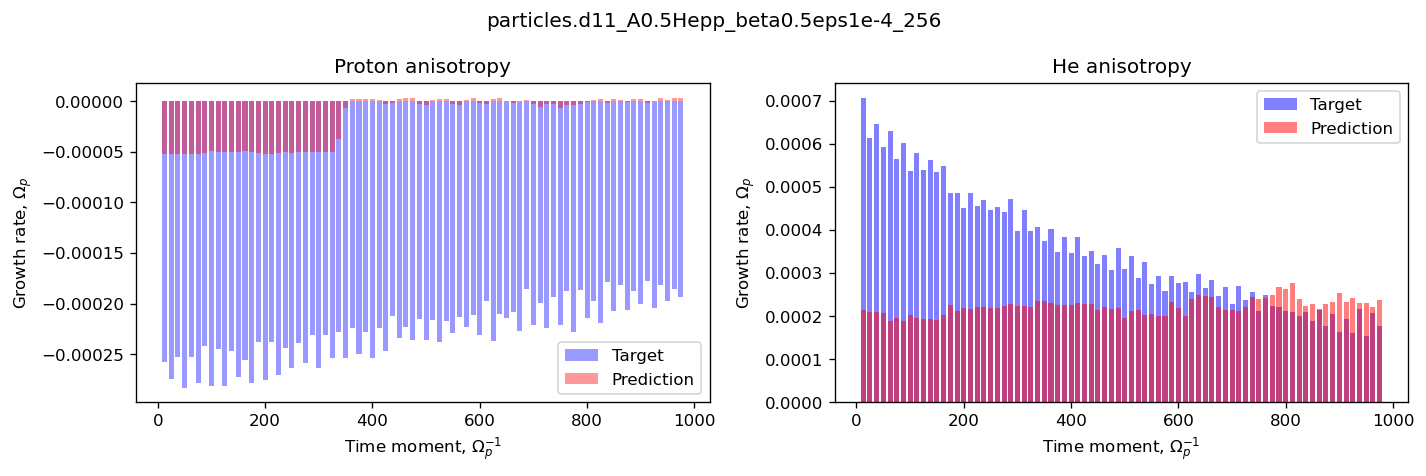

------------------------------------------------
PROCESSING SIMFILE: particles.d11_A0.75Hepp_beta1_256


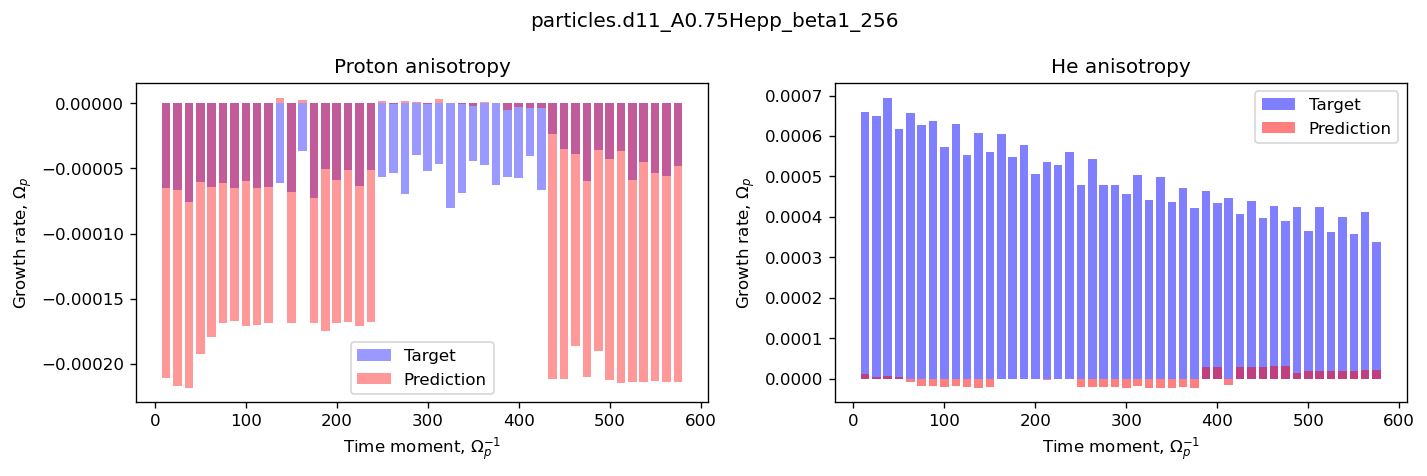

------------------------------------------------
PROCESSING SIMFILE: particles.d11_E11Ap3.3Aa2.0Vd0.42


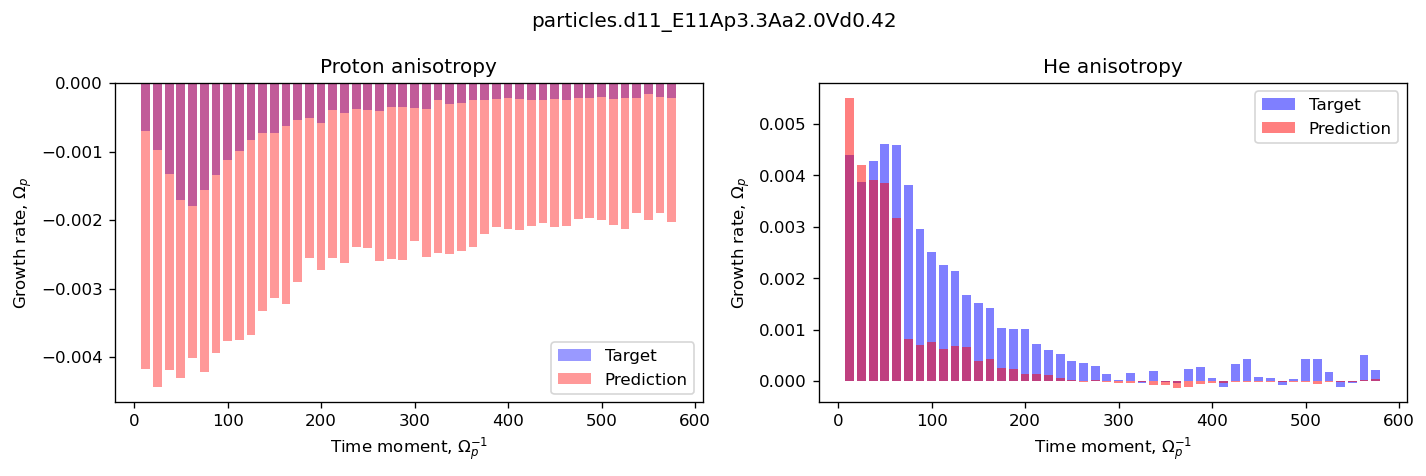

------------------------------------------------
PROCESSING SIMFILE: particles.d11_E11Ap4.3Aa1.6


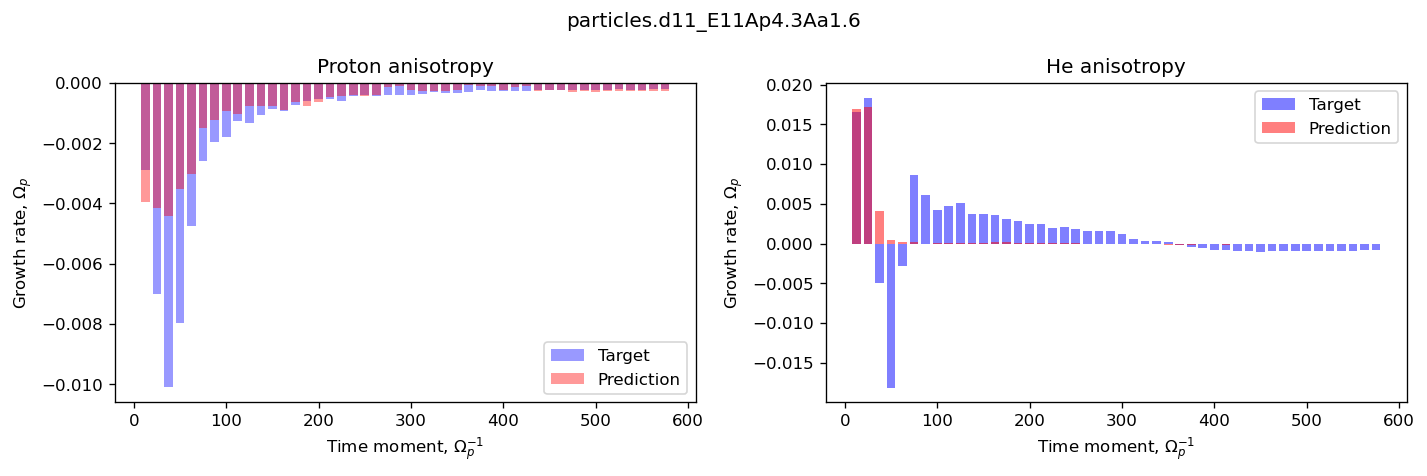

------------------------------------------------
PROCESSING SIMFILE: particles.d11_E11Ap4.3Aa1.6Vd0.32


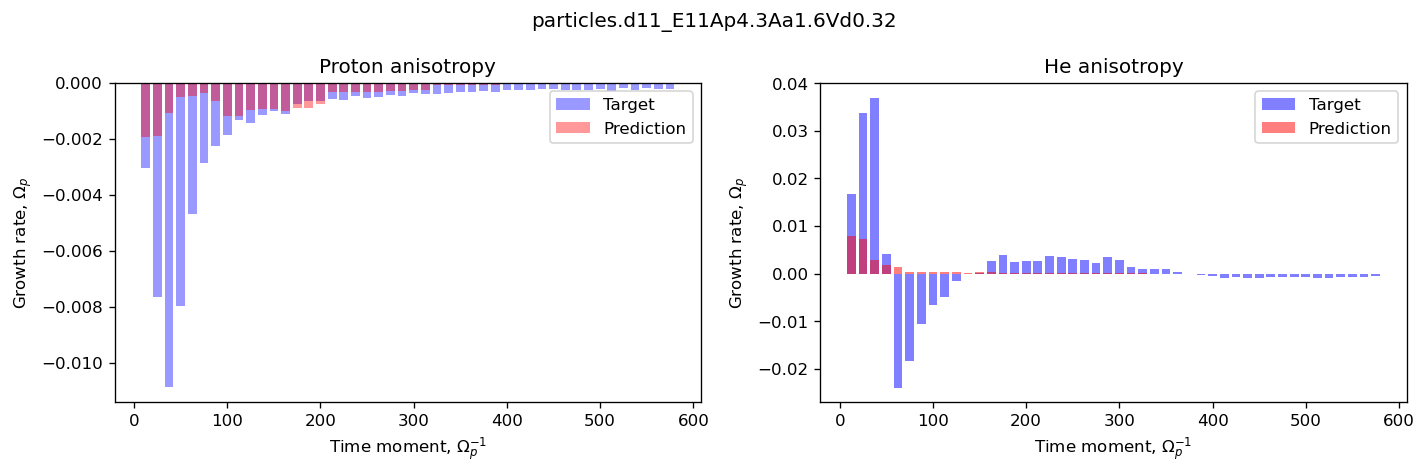

------------------------------------------------
PROCESSING SIMFILE: particles.d11_E12Ap1.86Aa1.0Vd0.32_256_256x256


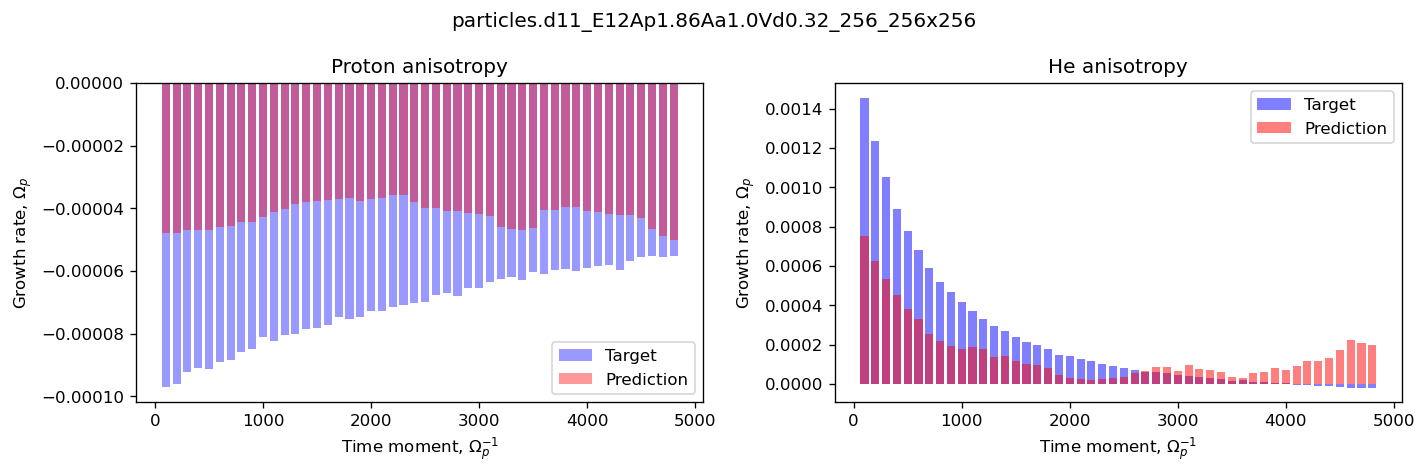

------------------------------------------------
PROCESSING SIMFILE: particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256


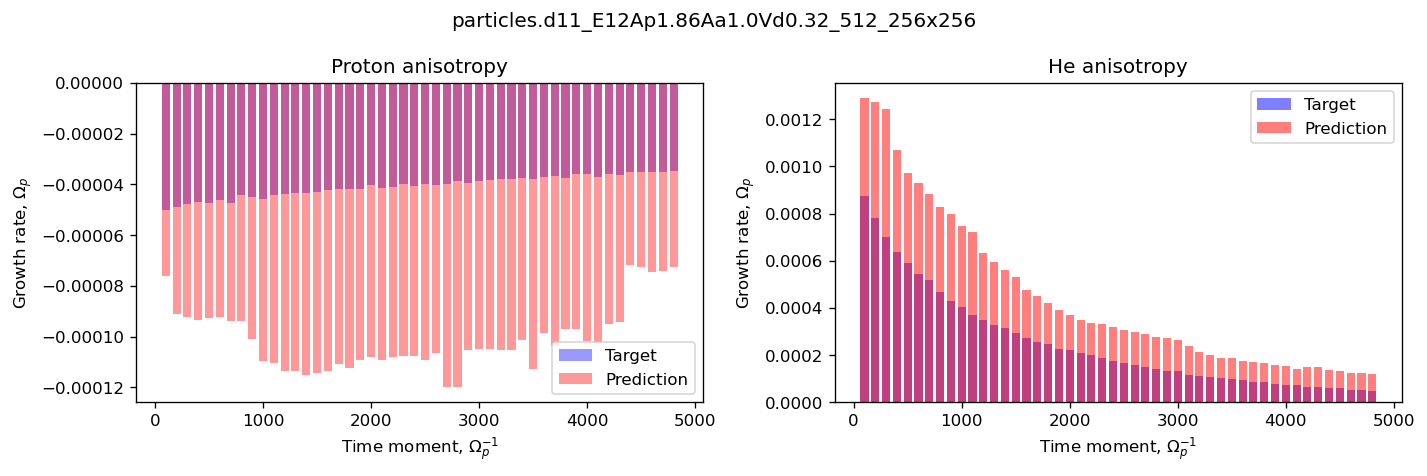

------------------------------------------------
PROCESSING SIMFILE: particles.d11_He++A10_256_iden0eps0


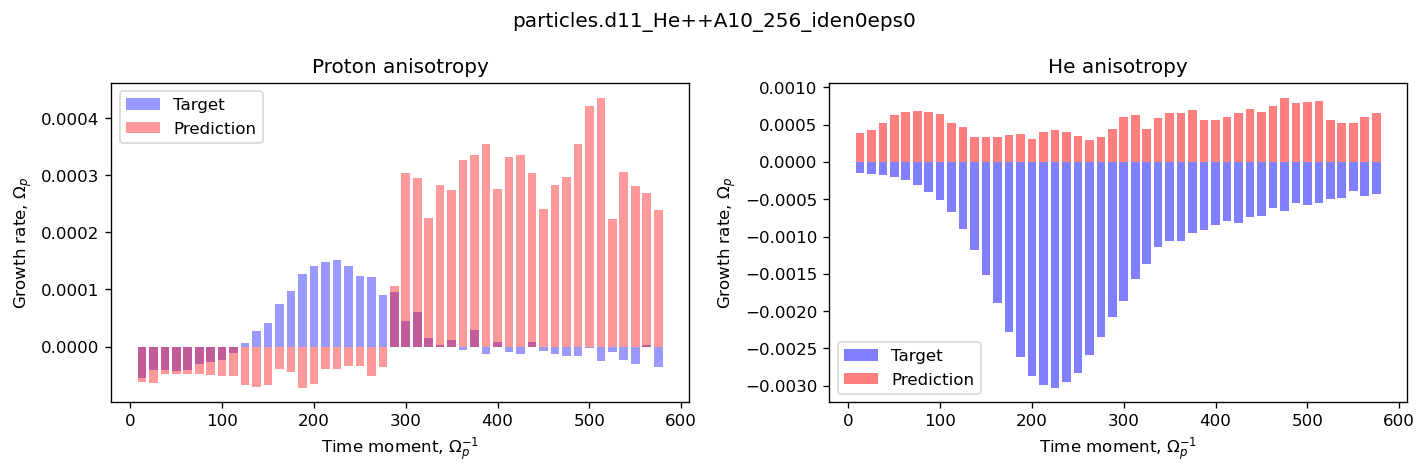

------------------------------------------------
PROCESSING SIMFILE: particles.d11_He++v2_256_iden0eps1e-4t600


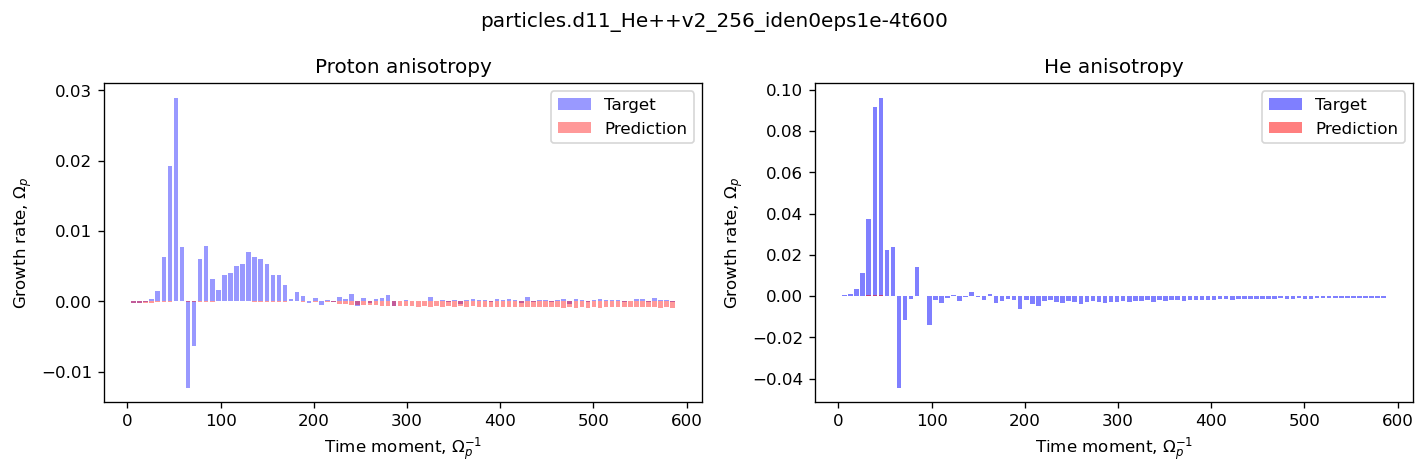

------------------------------------------------
PROCESSING SIMFILE: particles.d11_He++vd1.5_256_iden0eps1e-4


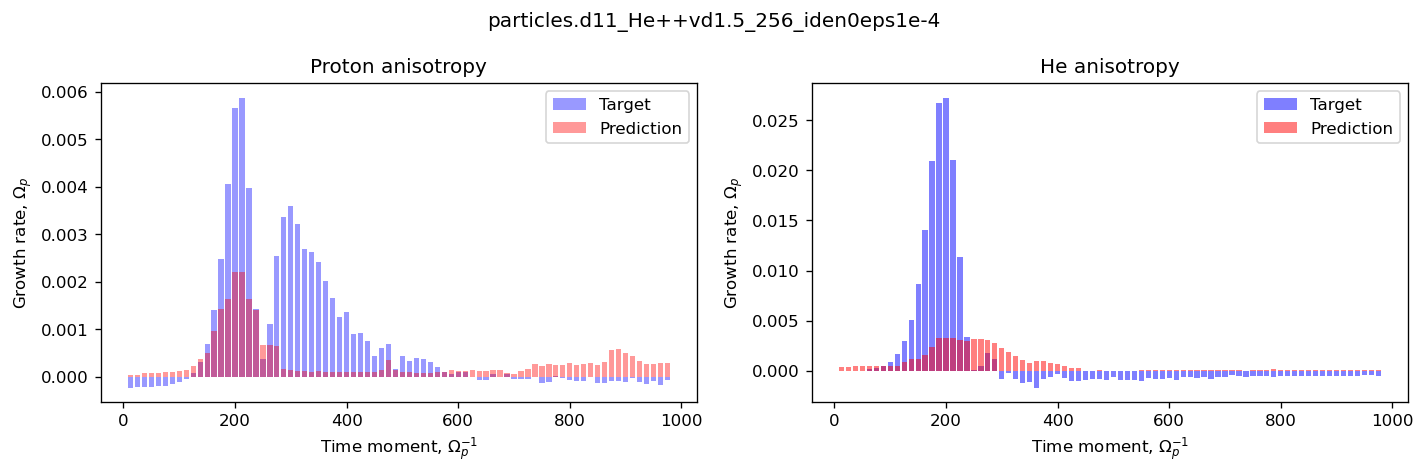

------------------------------------------------
PROCESSING SIMFILE: particles.d11_pv1.5_128_64_iden0eps1e-4_dx0.75_long


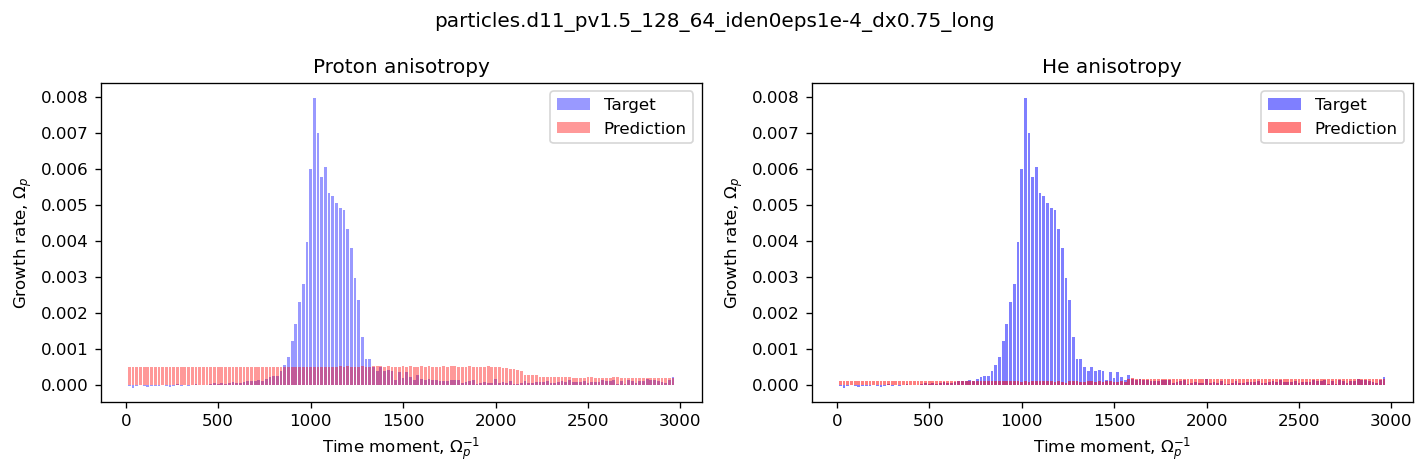

------------------------------------------------
PROCESSING SIMFILE: particles.d11_pv1Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000


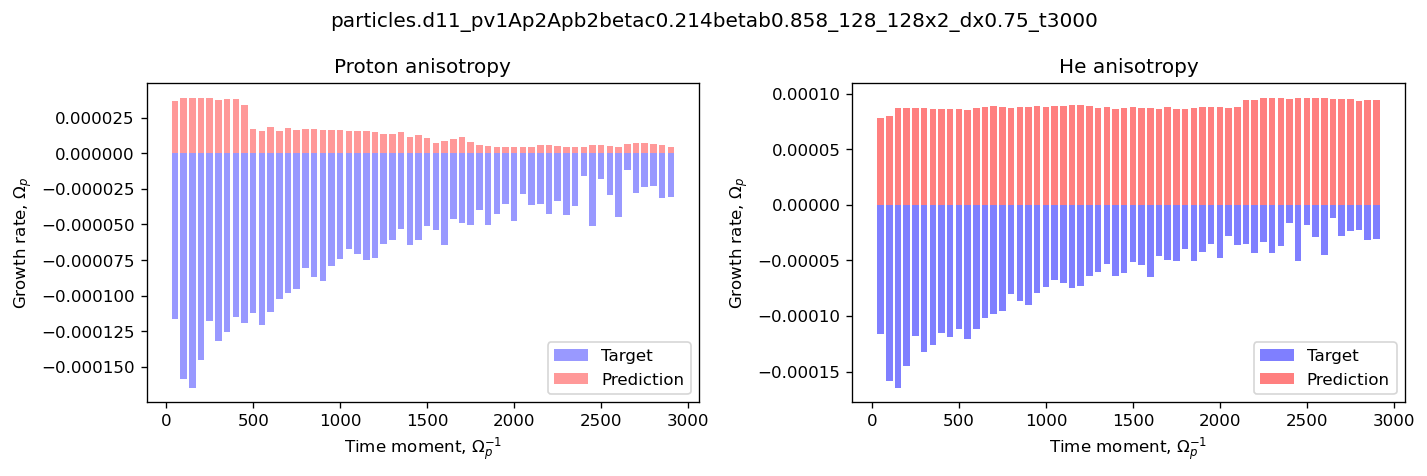

------------------------------------------------
PROCESSING SIMFILE: particles.d11_pv2a_128x3_iden0eps1e-4_dx0.75


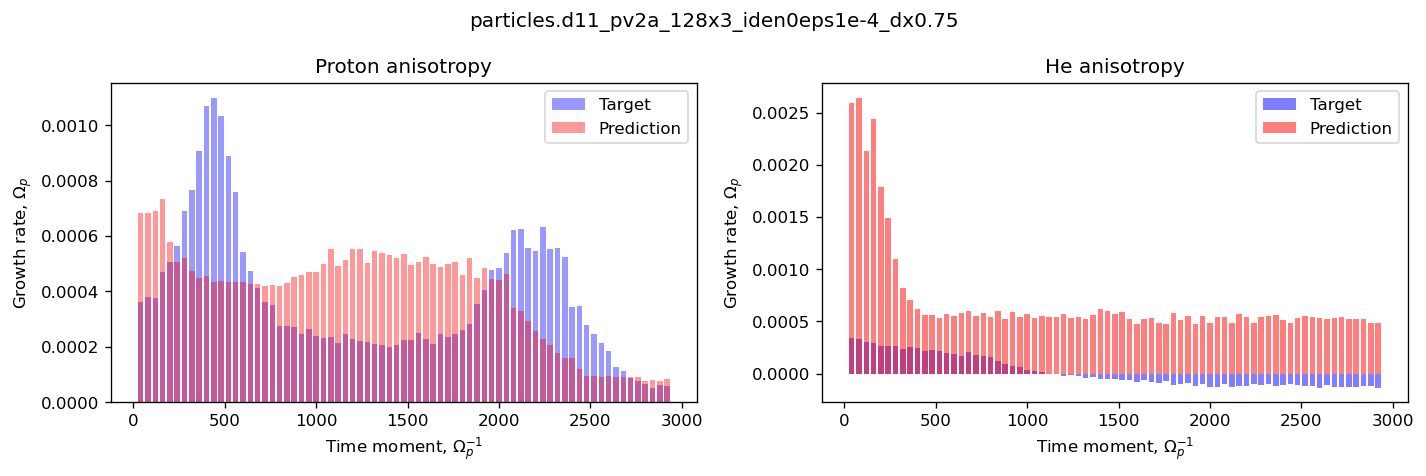

------------------------------------------------
PROCESSING SIMFILE: particles.d11_pv2Ap1Ab1betac0.429betab0.858_128_128x2_dx0.75_t3000


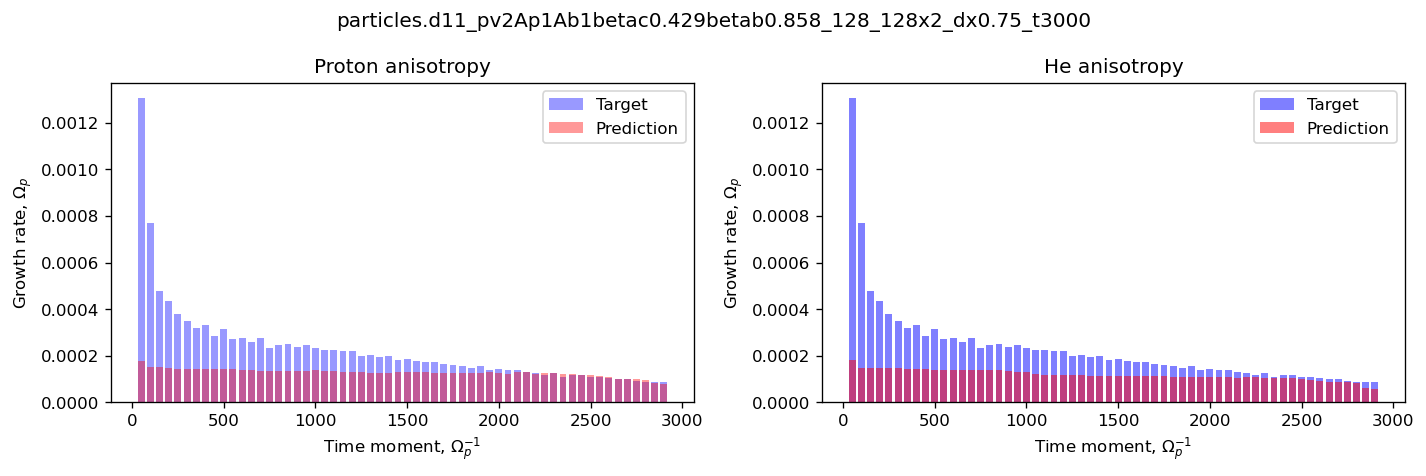

------------------------------------------------
PROCESSING SIMFILE: particles.d11_pv2Ap1Ab2betac0.429betab0.858_128_128x2_dx0.75_t3000


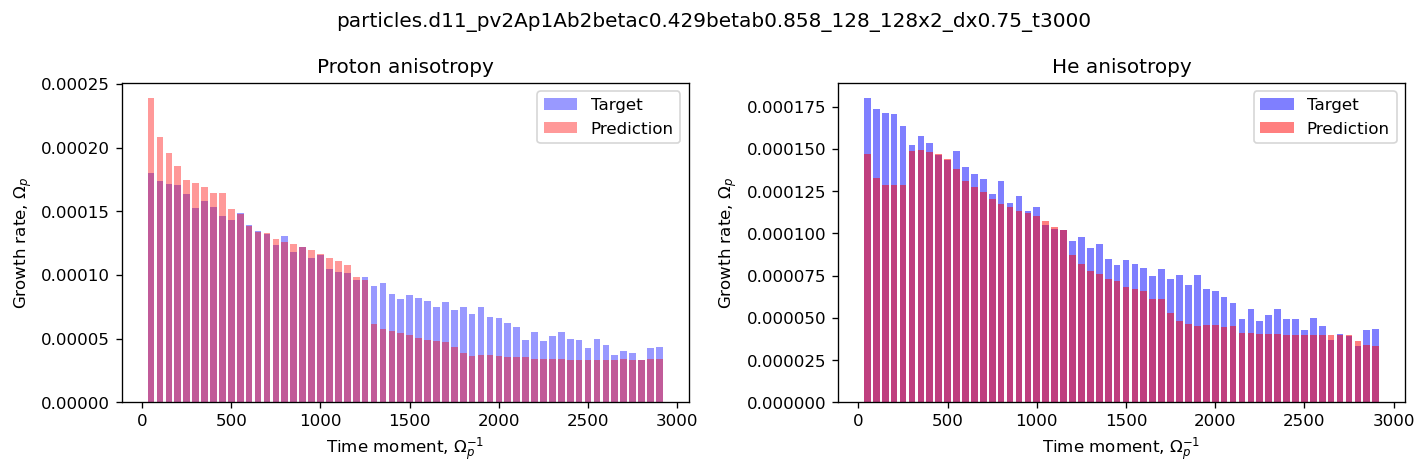

------------------------------------------------
PROCESSING SIMFILE: particles.d11_pv2Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000


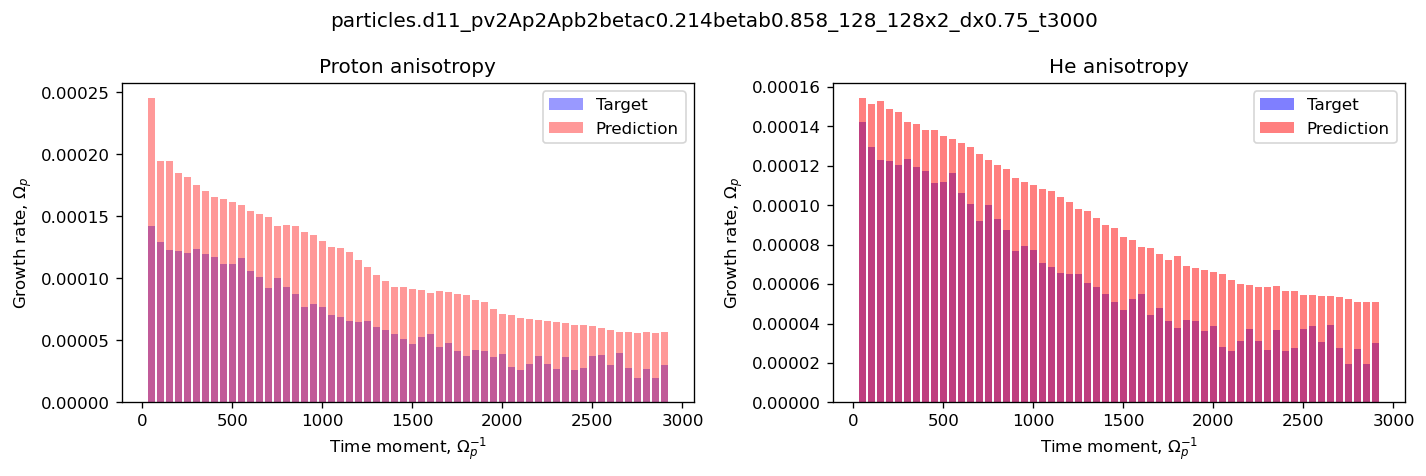

------------------------------------------------
PROCESSING SIMFILE: particles.d11_pv2av2.3_128x3_iden0eps1e-4_dx0.75


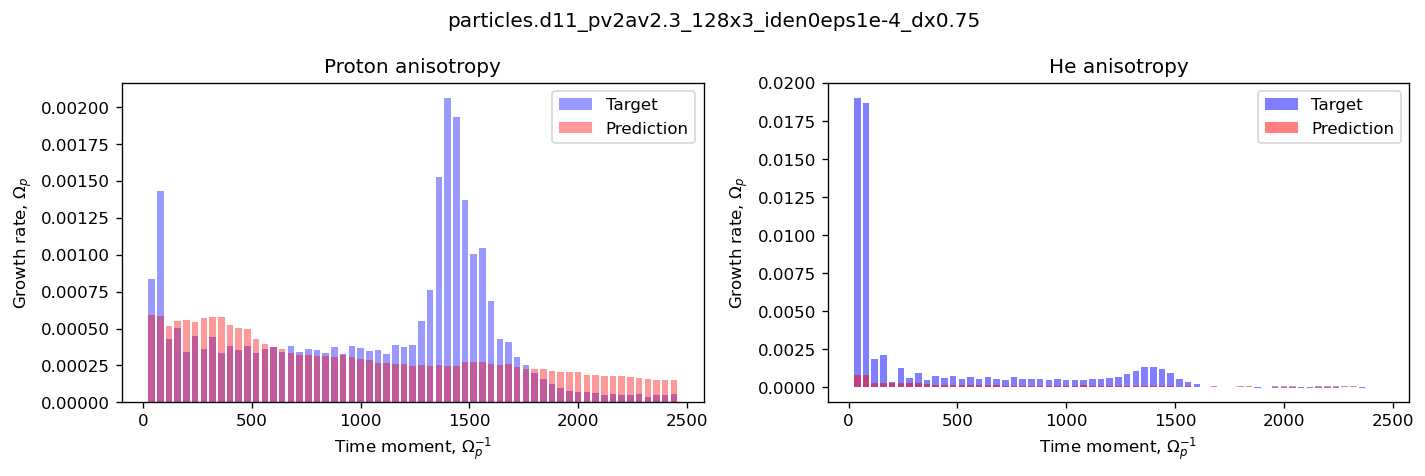

------------------------------------------------
PROCESSING SIMFILE: particles.d11_pv2av2Ap1Aa1beta0.429_128_128x2_dx0.75_t3000


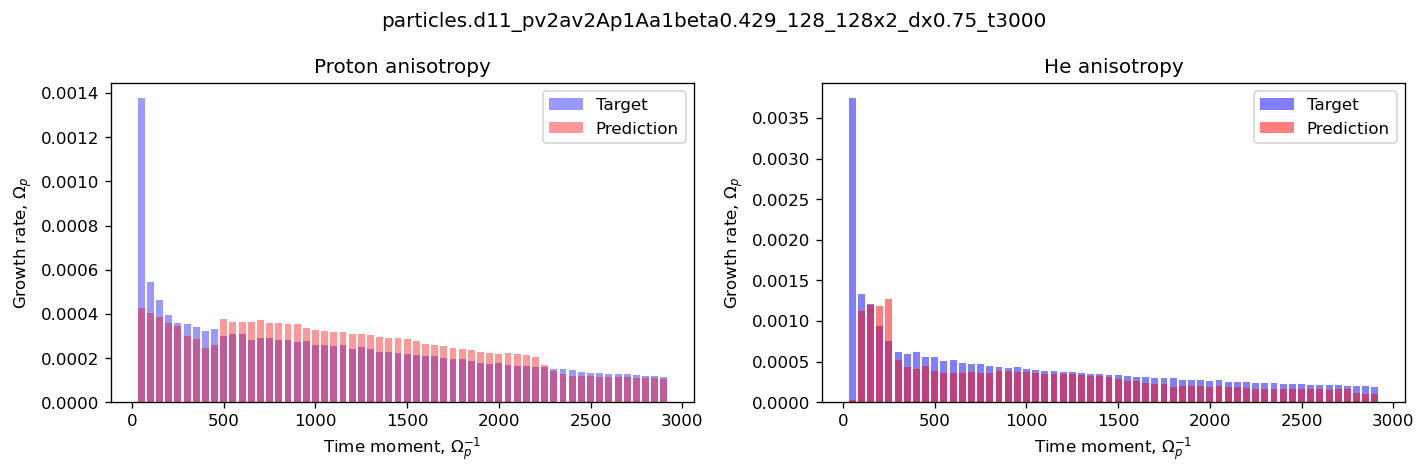

------------------------------------------------
PROCESSING SIMFILE: particles.d11_pv2av2_rdna0.03375_128x3_iden0eps1e-4_dx0.75_t6000


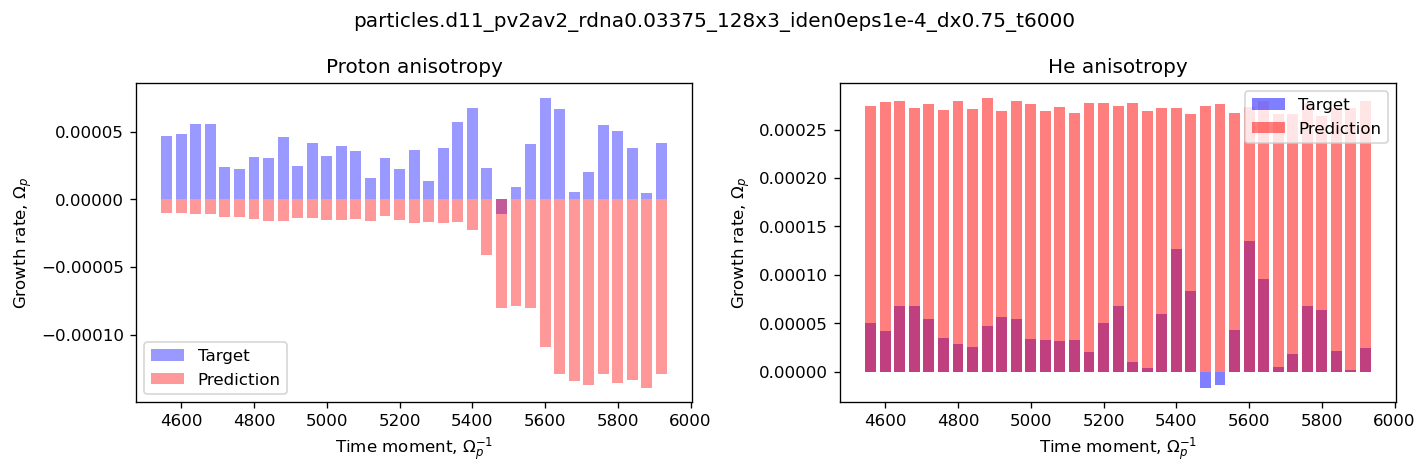

------------------------------------------------
PROCESSING SIMFILE: particles.d11_vap1.2Ap1Aa0.75_rdna_0.05


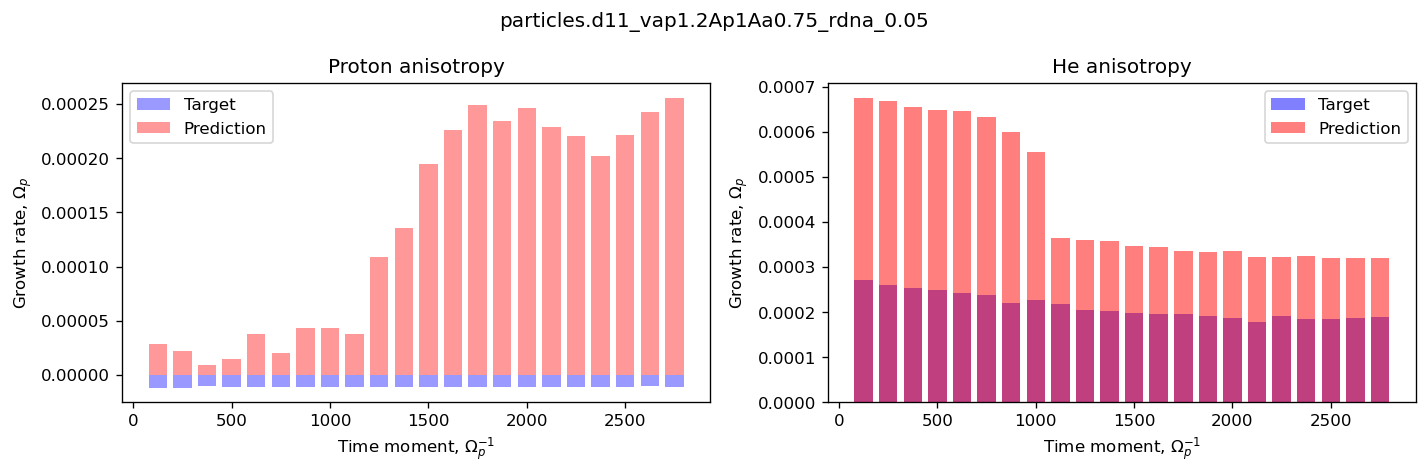

------------------------------------------------
PROCESSING SIMFILE: particles.d11_vap1.2Ap3.35Aa2.05rdna_0.007


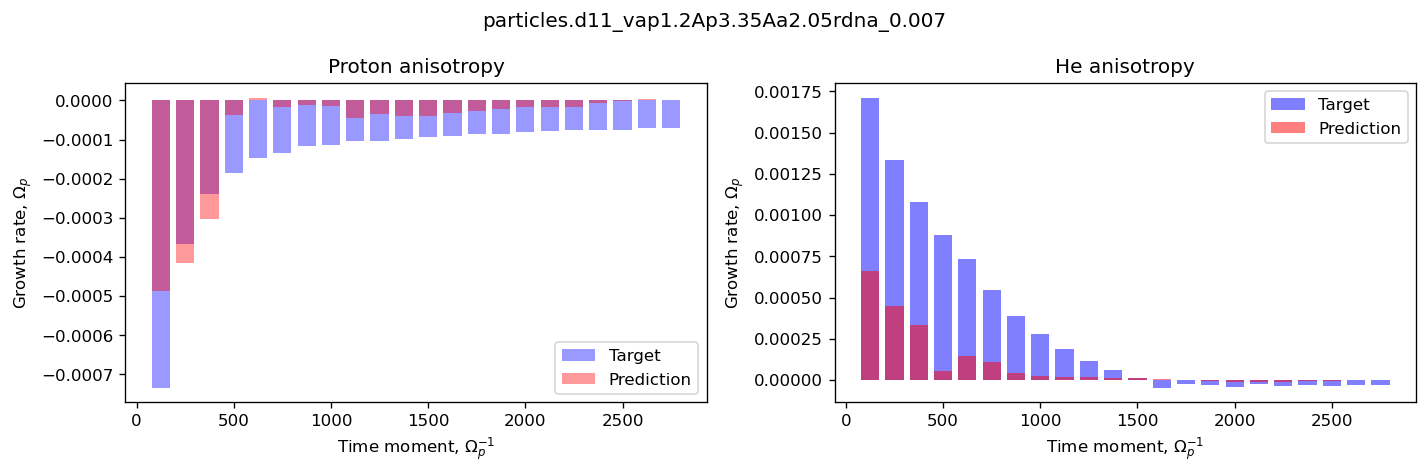

------------------------------------------------
PROCESSING SIMFILE: particles.d11_vap1.5Ap1.5Aa1rdna_0.007


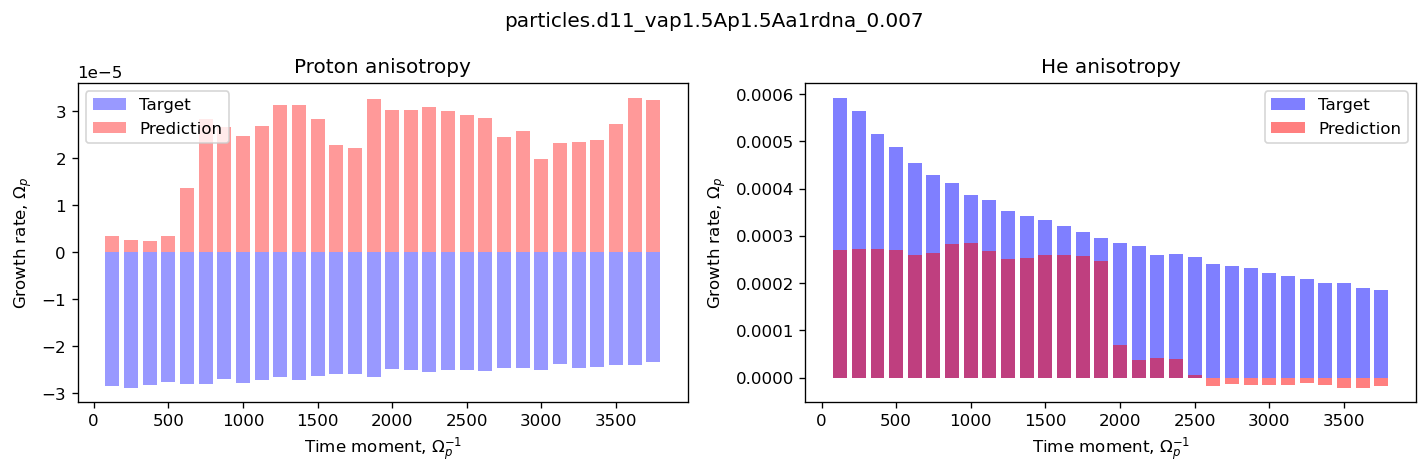

In [41]:
# organizing training and testing for every simfile in its absence
msescores = []
for simfile in simfiles:
    print("------------------------------------------------")
    print("PROCESSING SIMFILE: " + simfile)
    train_index = np.where(simnames != simfile)[0]
    test_index = np.where(simnames == simfile)[0]
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = rates_an[train_index], rates_an[test_index]
    t_train, t_test = times_allmoments[train_index], times_allmoments[test_index]
    # best performing regressor was RF; testing on it for the beginning
    regressor = MultiOutputRegressor(RandomForestRegressor(max_depth = 25, n_estimators = 200))
    regressor.fit(X_train, f_train)
    f_predicted = regressor.predict(X_test)
    # transforming the rates back
    f_test_inv = transform_inverse(f_test)
    f_pred_inv = transform_inverse(f_predicted)
    msescores.append(output_msescores_inverse(f_test, f_predicted))
    visualize_run(f_test_inv[:,0], f_pred_inv[:,0], f_test_inv[:,1], f_pred_inv[:,1], t_test, simfile)
    
msescores = np.array(msescores, dtype=float)

In [43]:
print(msescores.shape)
print("MSE(p) = " + str(np.mean(msescores[:,0])) + "+/-" + str(np.std(msescores[:,0])))
print("MSE(He) = " + str(np.mean(msescores[:,1])) + "+/-" + str(np.std(msescores[:,1])))

(22, 2)
MSE(p) = 0.000695766104293343+/-0.0010981203033093316
MSE(He) = 0.0020594059495591373+/-0.0036643916303742054


------------------------------------------------
PROCESSING SIMFILE: particles.d11_A0.5Hepp_beta0.5eps1e-4_256


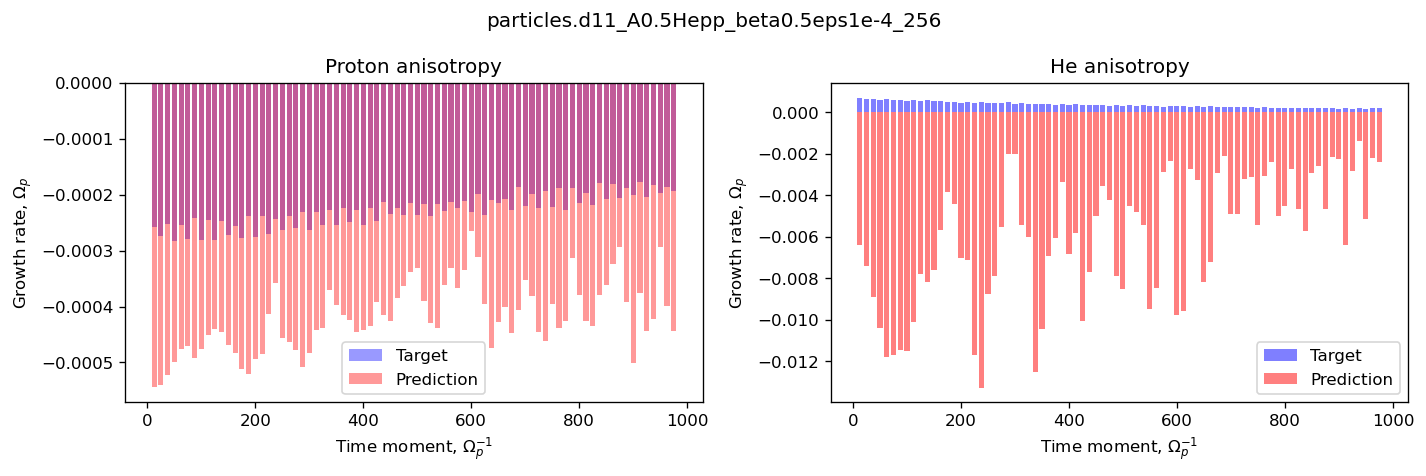

------------------------------------------------
PROCESSING SIMFILE: particles.d11_A0.75Hepp_beta1_256


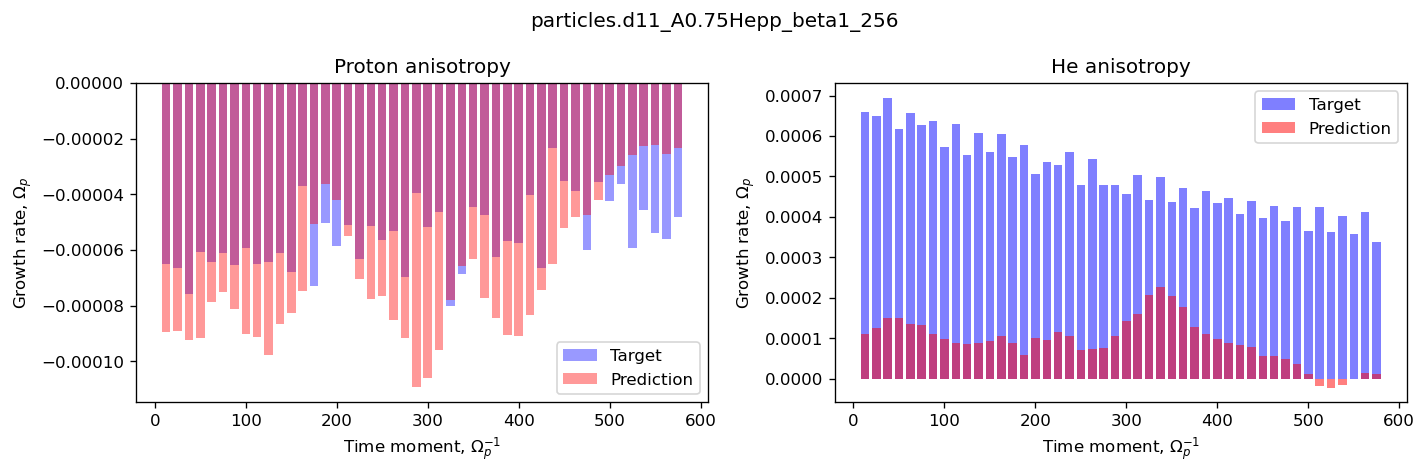

------------------------------------------------
PROCESSING SIMFILE: particles.d11_E11Ap3.3Aa2.0Vd0.42


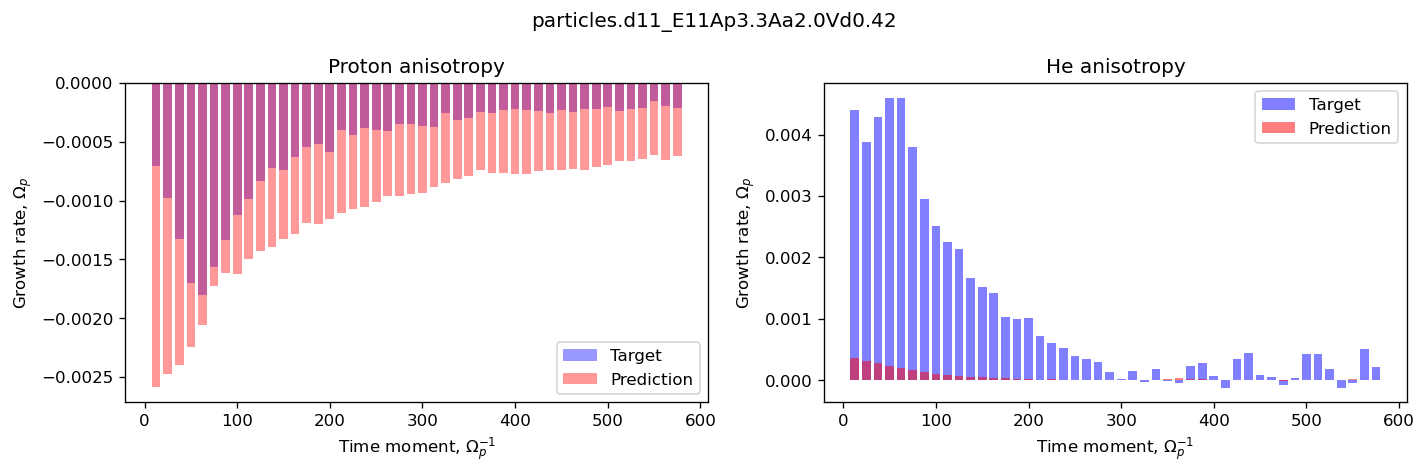

------------------------------------------------
PROCESSING SIMFILE: particles.d11_E11Ap4.3Aa1.6


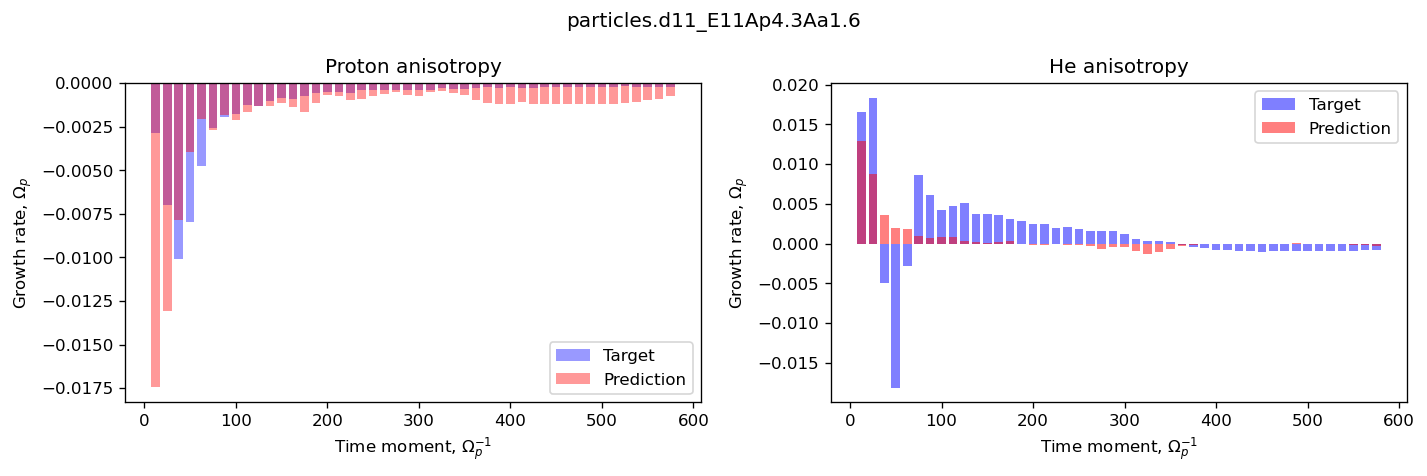

------------------------------------------------
PROCESSING SIMFILE: particles.d11_E11Ap4.3Aa1.6Vd0.32


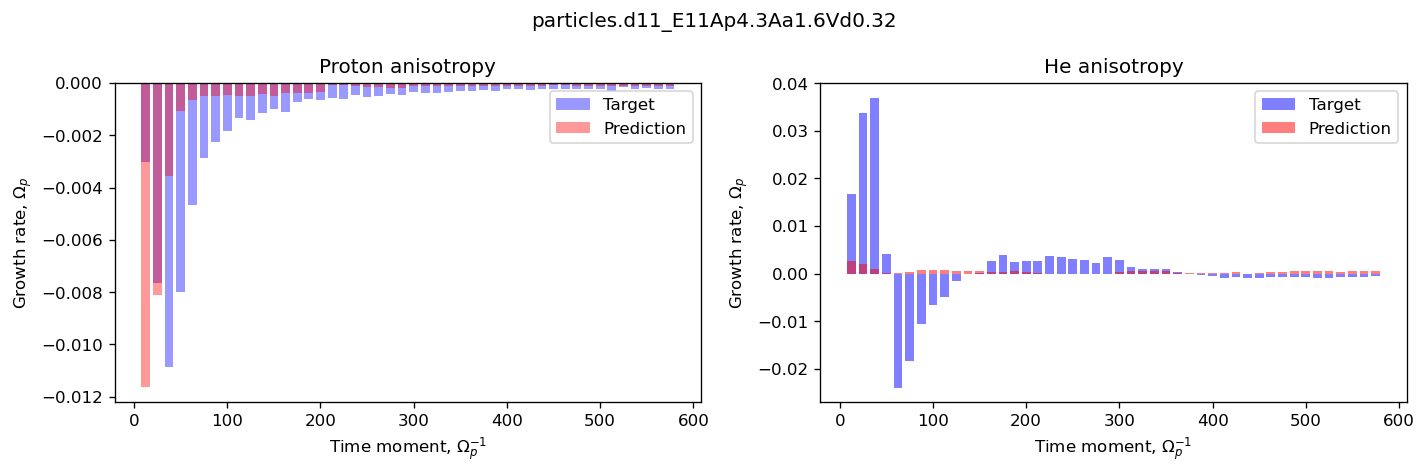

------------------------------------------------
PROCESSING SIMFILE: particles.d11_E12Ap1.86Aa1.0Vd0.32_256_256x256


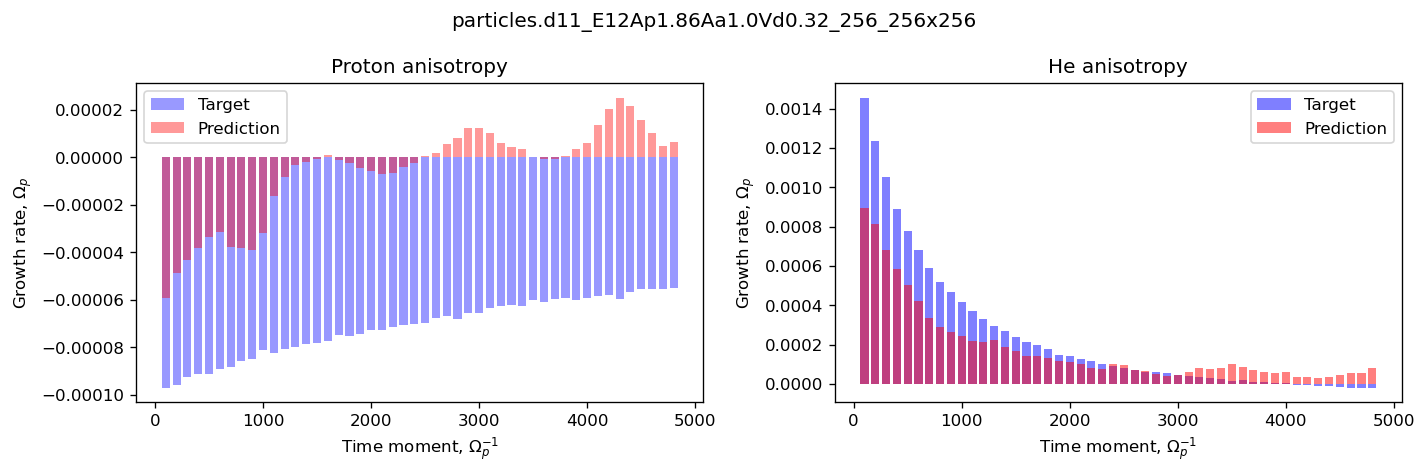

------------------------------------------------
PROCESSING SIMFILE: particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256


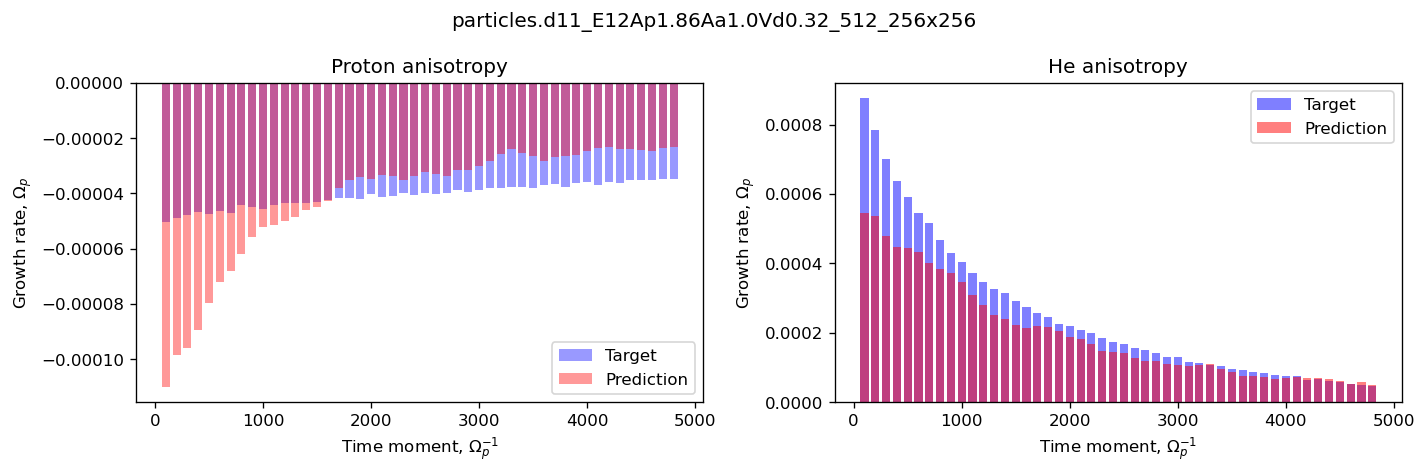

------------------------------------------------
PROCESSING SIMFILE: particles.d11_He++A10_256_iden0eps0


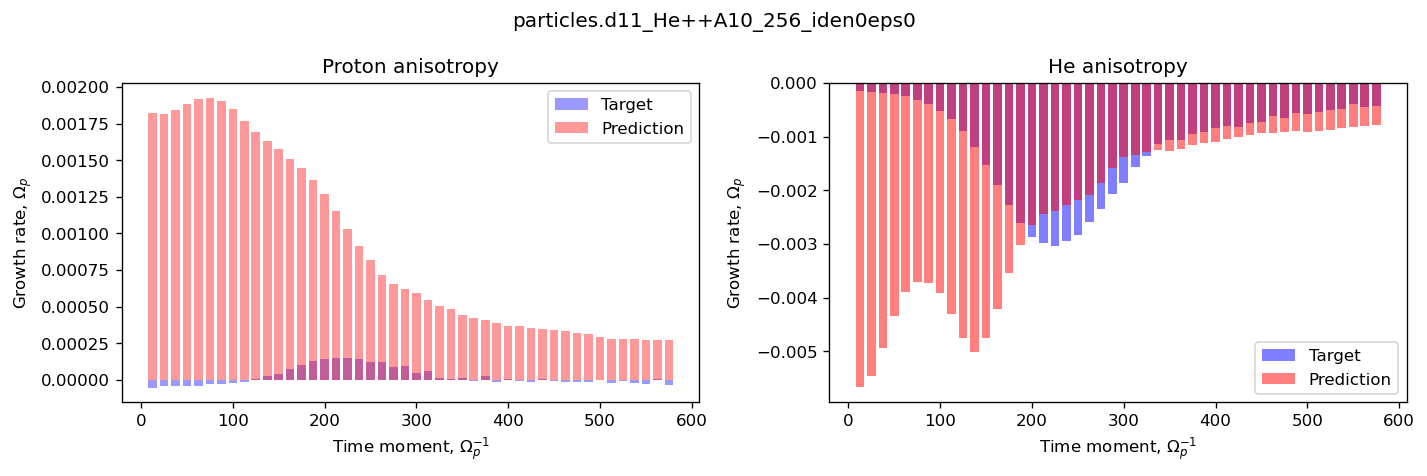

------------------------------------------------
PROCESSING SIMFILE: particles.d11_He++v2_256_iden0eps1e-4t600


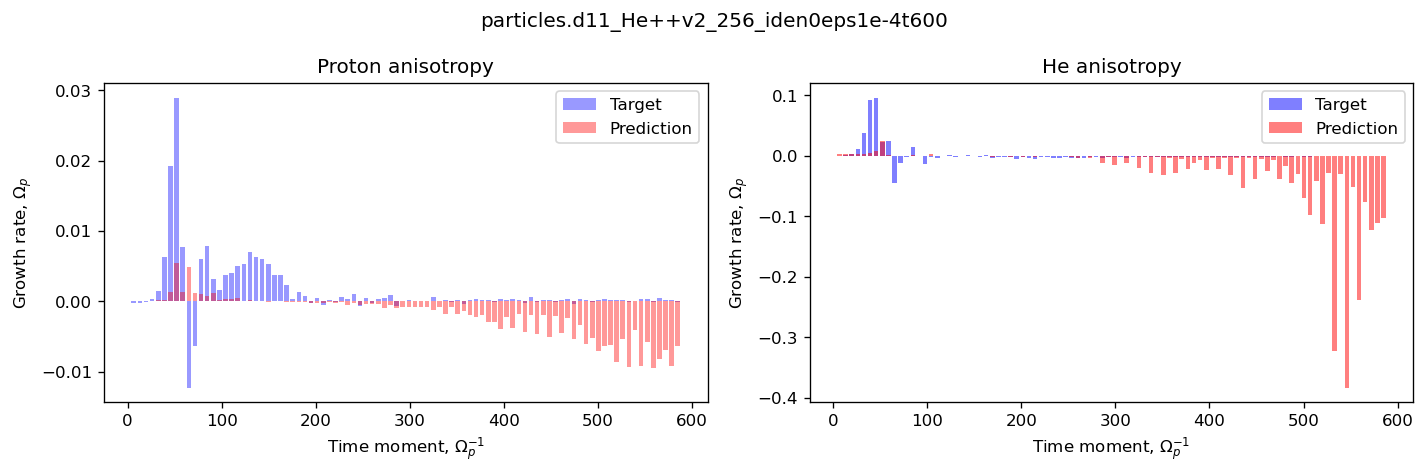

------------------------------------------------
PROCESSING SIMFILE: particles.d11_He++vd1.5_256_iden0eps1e-4


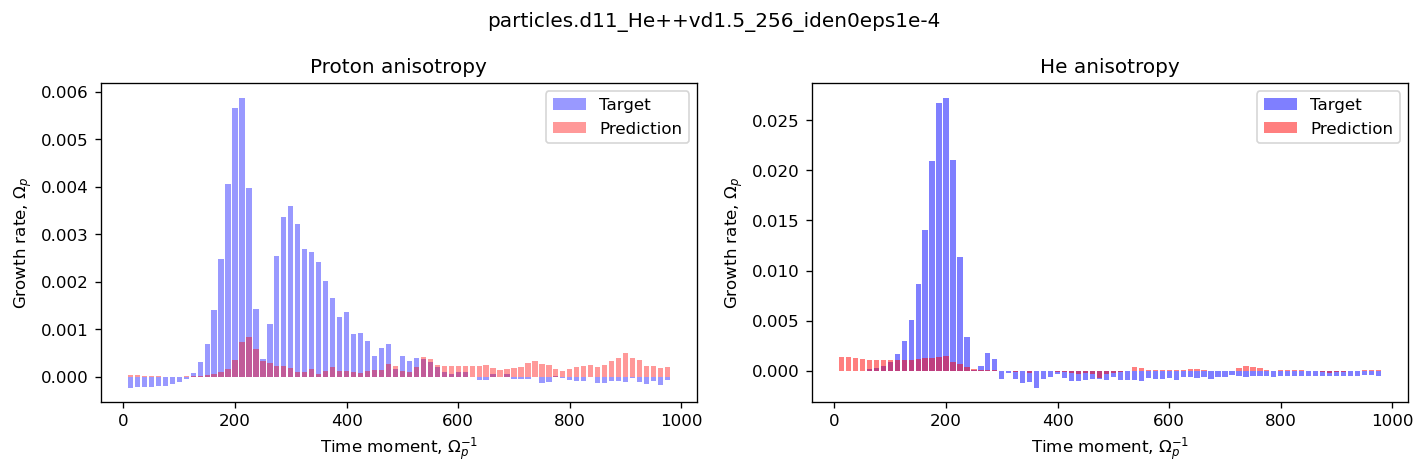

------------------------------------------------
PROCESSING SIMFILE: particles.d11_pv1.5_128_64_iden0eps1e-4_dx0.75_long


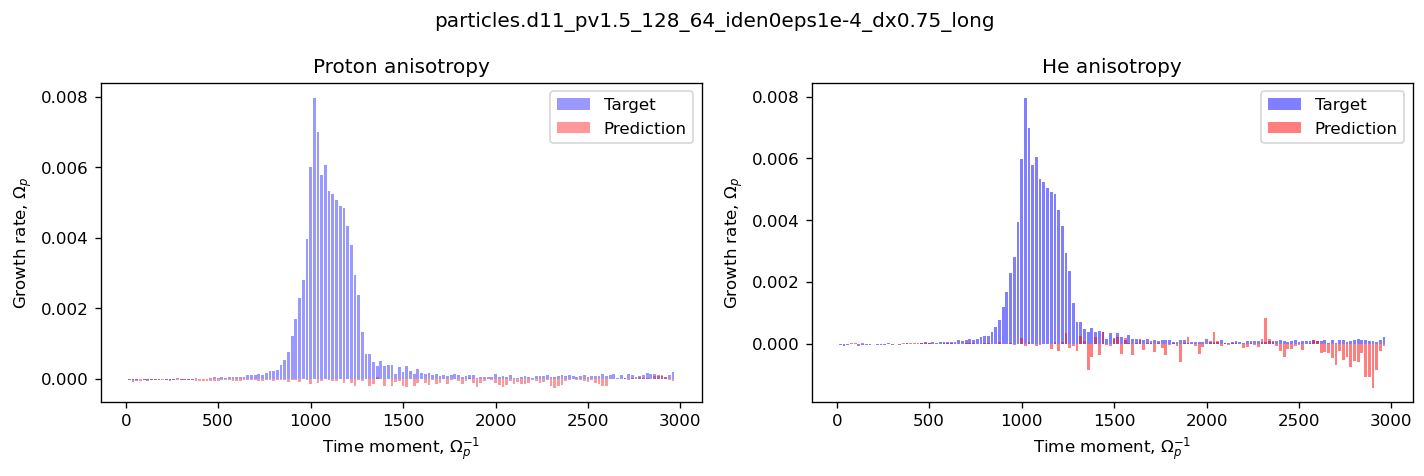

------------------------------------------------
PROCESSING SIMFILE: particles.d11_pv1Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000


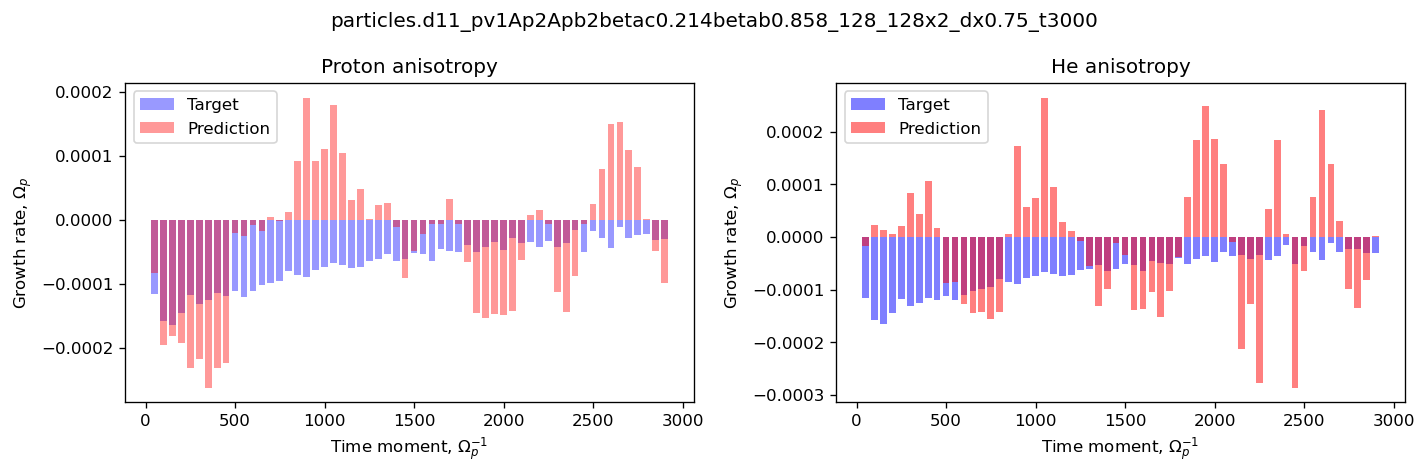

------------------------------------------------
PROCESSING SIMFILE: particles.d11_pv2a_128x3_iden0eps1e-4_dx0.75


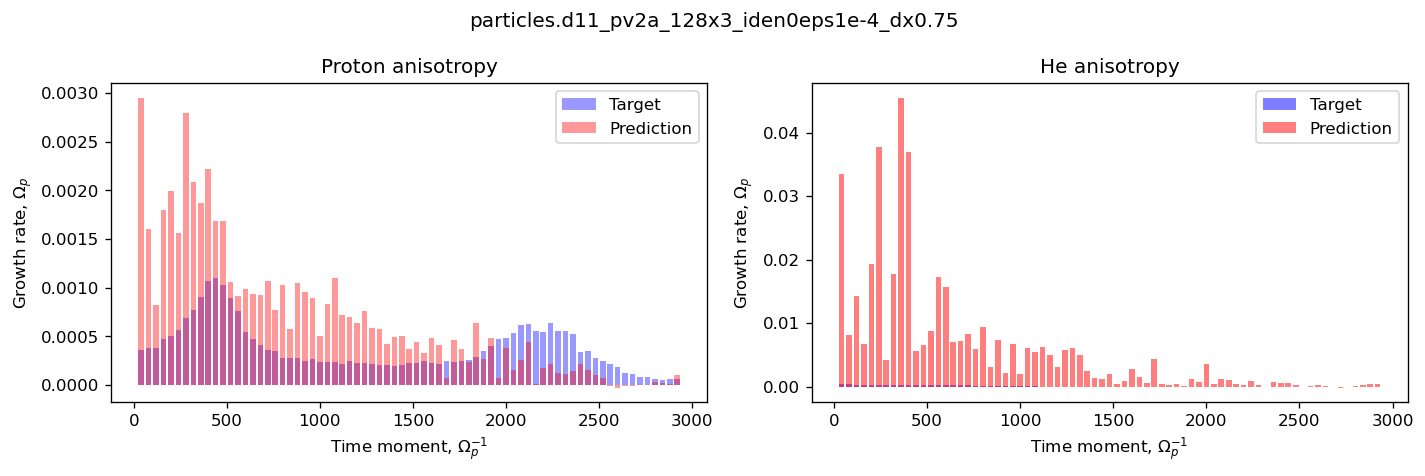

------------------------------------------------
PROCESSING SIMFILE: particles.d11_pv2Ap1Ab1betac0.429betab0.858_128_128x2_dx0.75_t3000


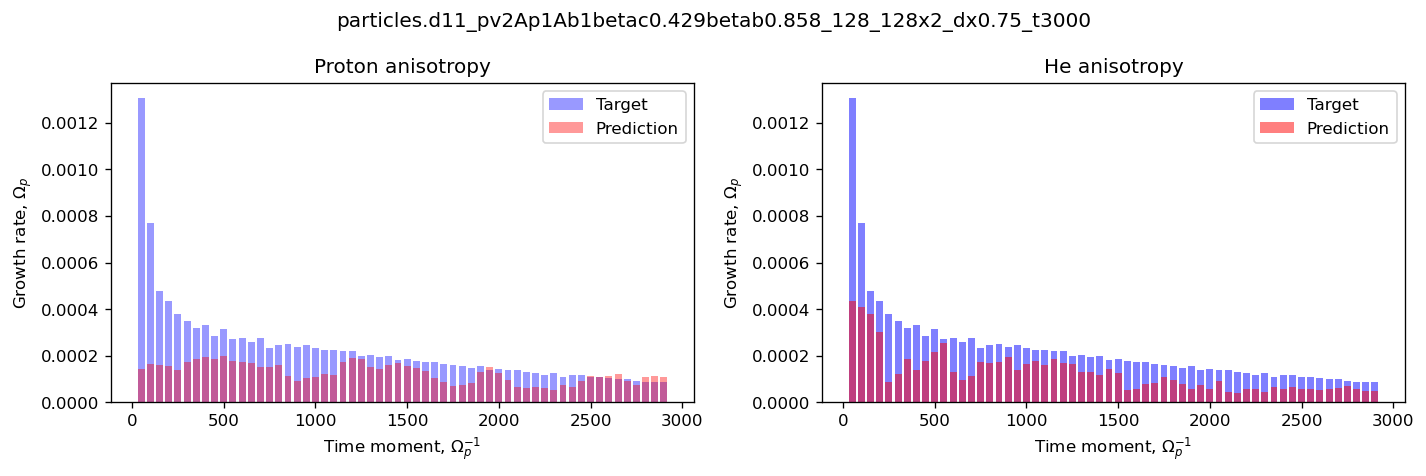

------------------------------------------------
PROCESSING SIMFILE: particles.d11_pv2Ap1Ab2betac0.429betab0.858_128_128x2_dx0.75_t3000


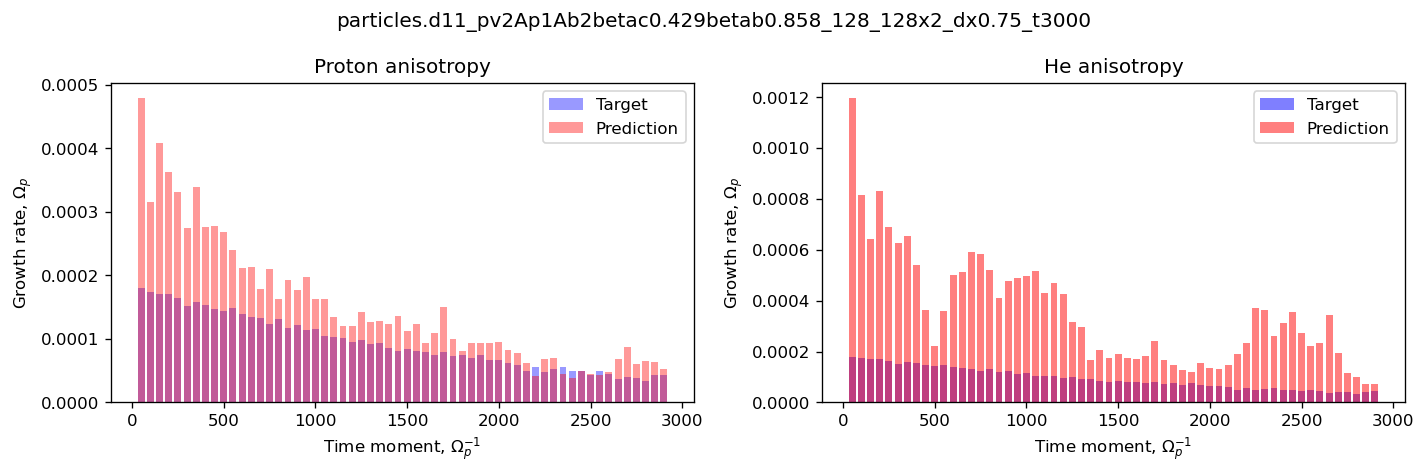

------------------------------------------------
PROCESSING SIMFILE: particles.d11_pv2Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000


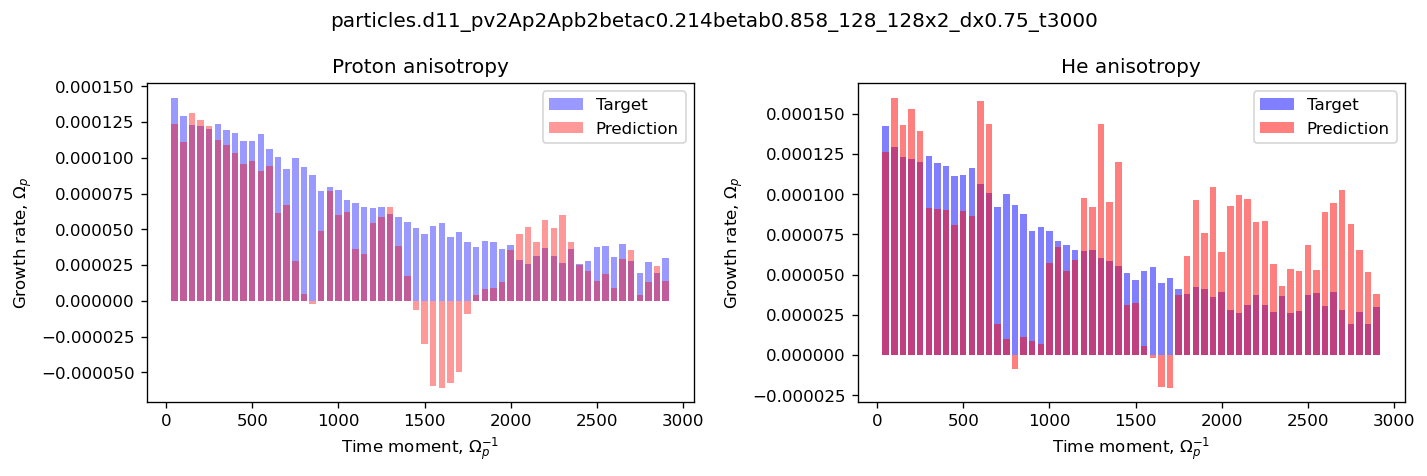

------------------------------------------------
PROCESSING SIMFILE: particles.d11_pv2av2.3_128x3_iden0eps1e-4_dx0.75


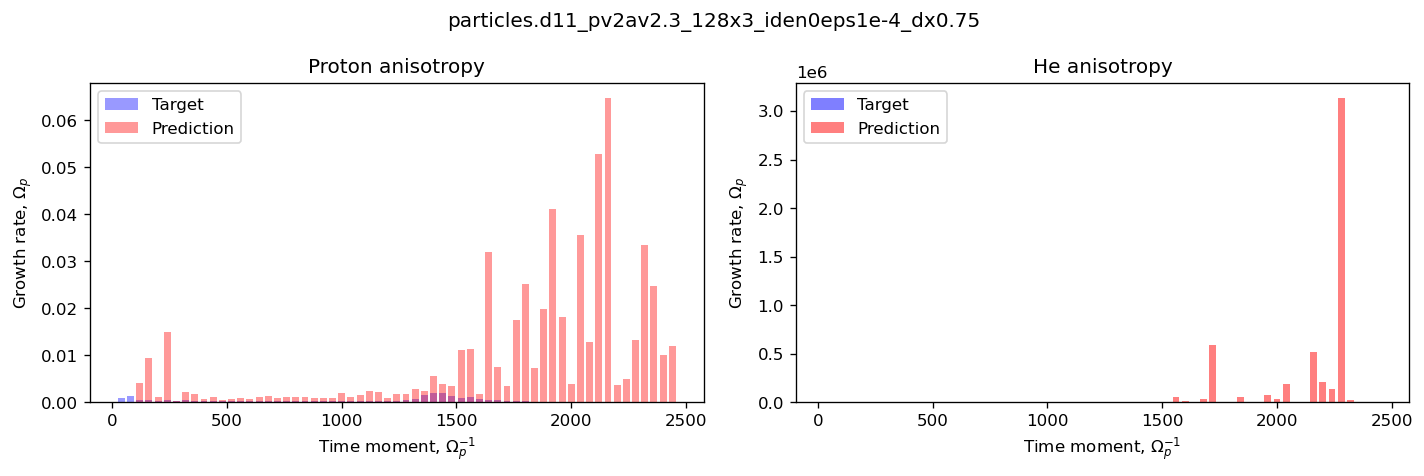

------------------------------------------------
PROCESSING SIMFILE: particles.d11_pv2av2Ap1Aa1beta0.429_128_128x2_dx0.75_t3000


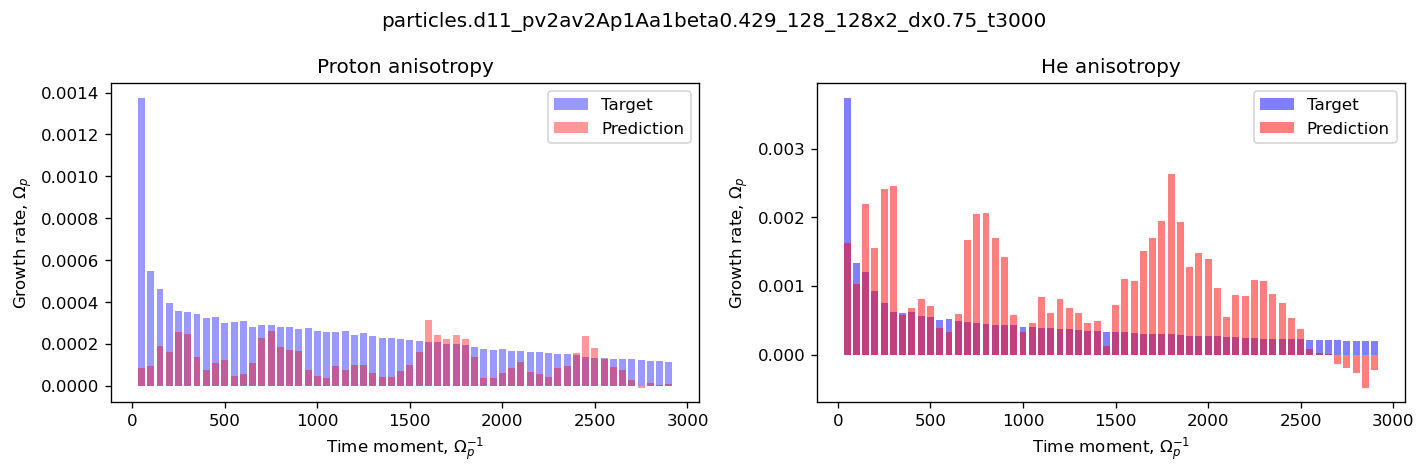

------------------------------------------------
PROCESSING SIMFILE: particles.d11_pv2av2_rdna0.03375_128x3_iden0eps1e-4_dx0.75_t6000


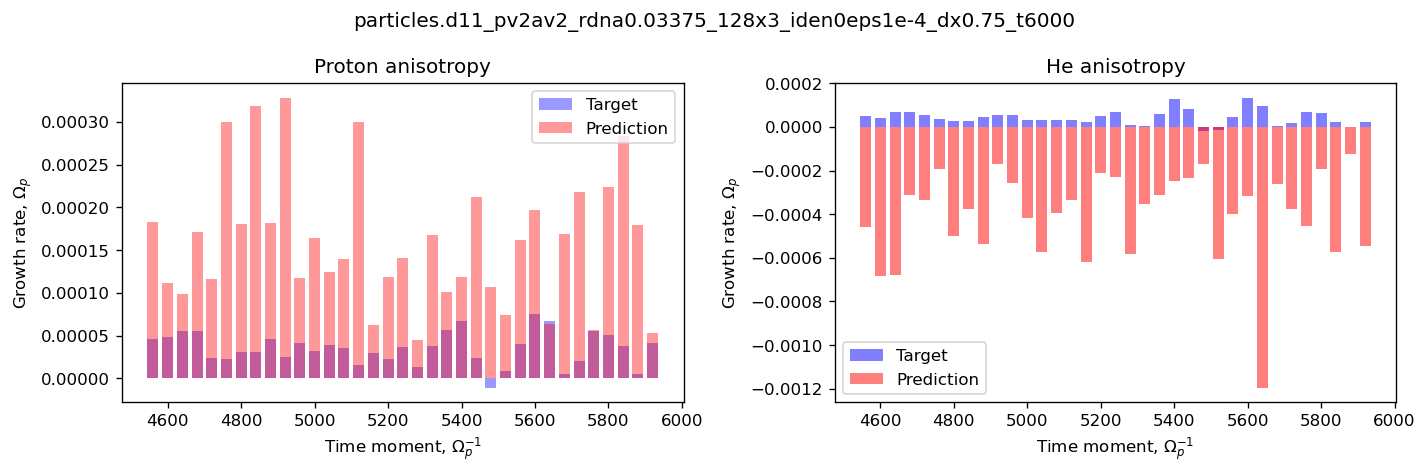

------------------------------------------------
PROCESSING SIMFILE: particles.d11_vap1.2Ap1Aa0.75_rdna_0.05


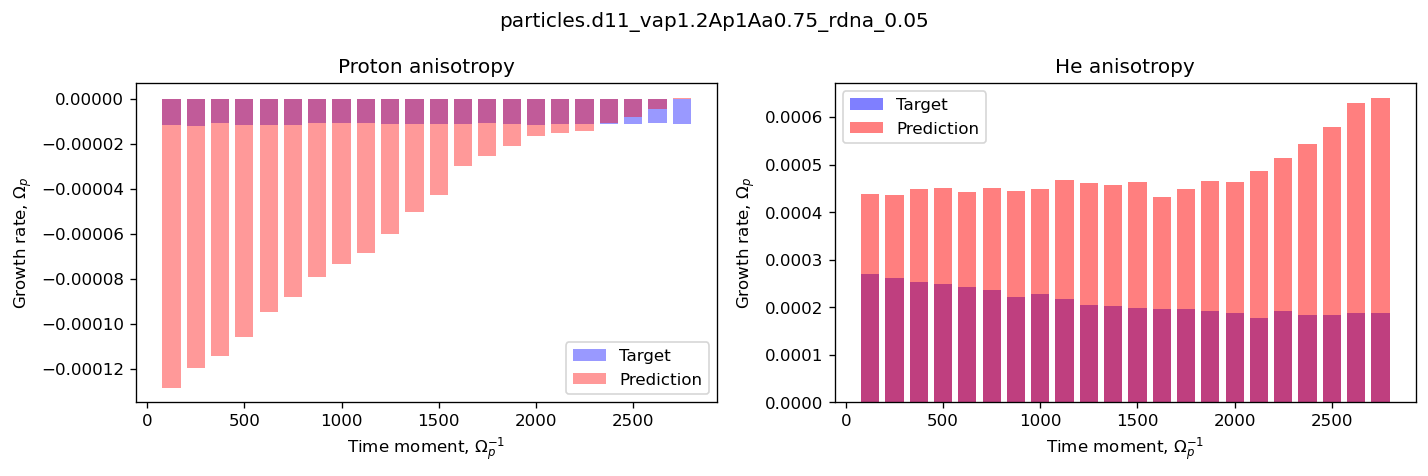

------------------------------------------------
PROCESSING SIMFILE: particles.d11_vap1.2Ap3.35Aa2.05rdna_0.007


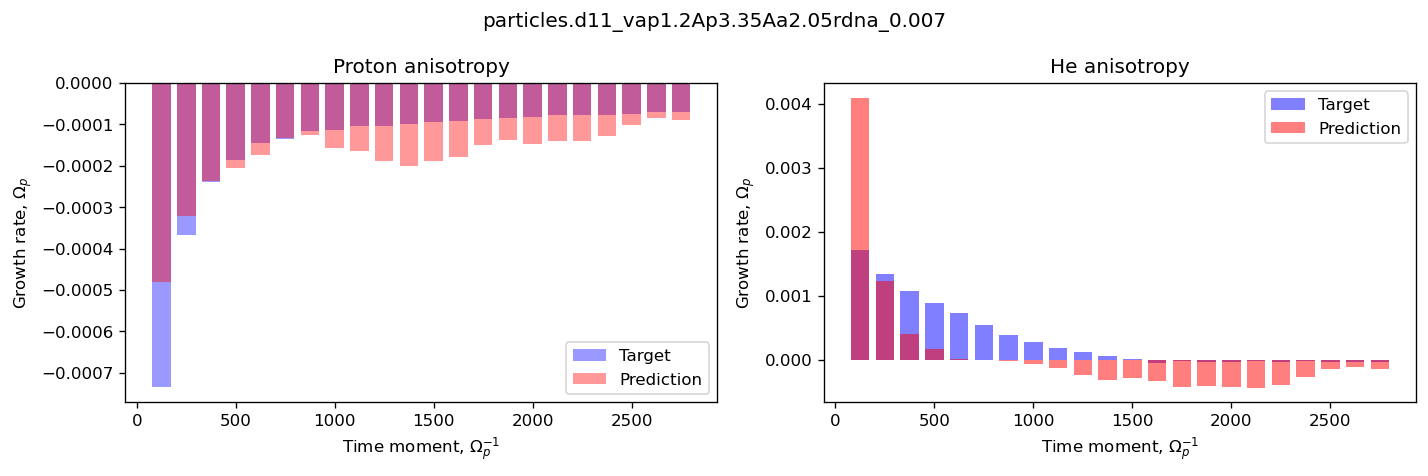

------------------------------------------------
PROCESSING SIMFILE: particles.d11_vap1.5Ap1.5Aa1rdna_0.007


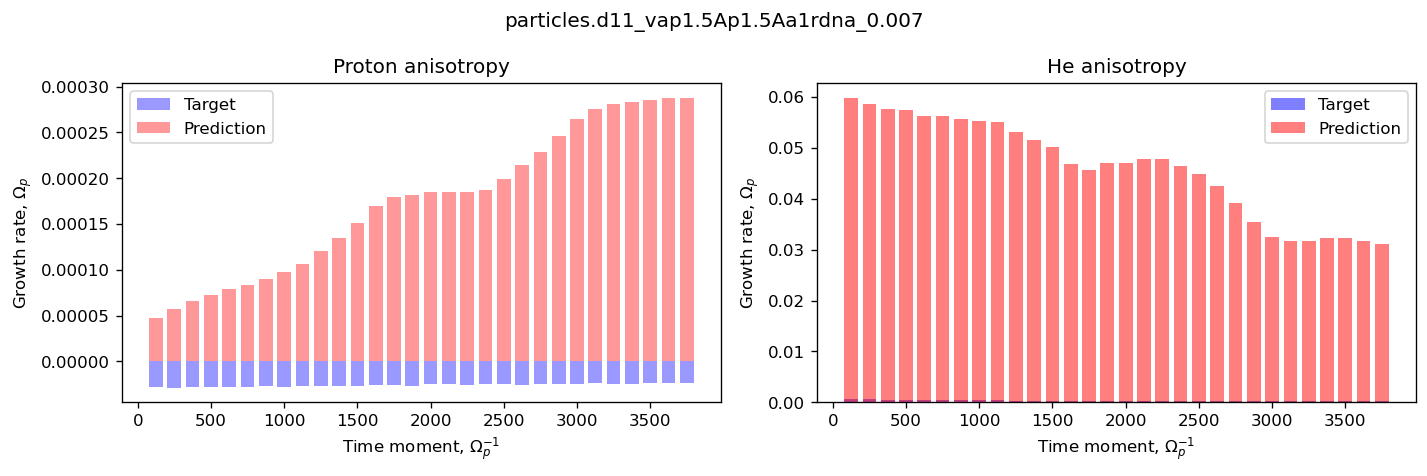

(22, 2)
MSE(p) = 0.0015093920283890305+/-0.003400281866115162
MSE(He) = 18903.603341277336+/-86627.15817568061


In [44]:
# organizing training and testing for every simfile in its absence
msescores = []
for simfile in simfiles:
    print("------------------------------------------------")
    print("PROCESSING SIMFILE: " + simfile)
    train_index = np.where(simnames != simfile)[0]
    test_index = np.where(simnames == simfile)[0]
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = rates_an[train_index], rates_an[test_index]
    t_train, t_test = times_allmoments[train_index], times_allmoments[test_index]
    # best performing regressor was RF; testing on it for the beginning
    regressor = MultiOutputRegressor(MLPRegressor(hidden_layer_sizes = (200,), max_iter = 10000))
    regressor.fit(X_train, f_train)
    f_predicted = regressor.predict(X_test)
    # transforming the rates back
    f_test_inv = transform_inverse(f_test)
    f_pred_inv = transform_inverse(f_predicted)
    msescores.append(output_msescores_inverse(f_test, f_predicted))
    visualize_run(f_test_inv[:,0], f_pred_inv[:,0], f_test_inv[:,1], f_pred_inv[:,1], t_test, simfile)
    
msescores = np.array(msescores, dtype=float)

print(msescores.shape)
print("MSE(p) = " + str(np.mean(msescores[:,0])) + "+/-" + str(np.std(msescores[:,0])))
print("MSE(He) = " + str(np.mean(msescores[:,1])) + "+/-" + str(np.std(msescores[:,1])))